<a href="https://colab.research.google.com/github/Zardian18/MuseGan_music/blob/master/Music_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-02-29 12:47:23--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23998 (23K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  23.44K  --.-KB/s    in 0.001s  

2024-02-29 12:47:24 (16.4 MB/s) - ‘helper.py’ saved [23998/23998]



In [2]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from helper import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

In [3]:
!pip install kaggle

In [4]:
from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [5]:
!kaggle datasets download -d soumikrakshit/classical-music-midi

  0% 0.00/2.33M [00:00<?, ?B/s]
100% 2.33M/2.33M [00:00<00:00, 116MB/s]


In [ ]:
!unzip /content/classical-music-midi.zip

In [7]:
!pip install --upgrade music21
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb
!sh -e /etc/init.d/x11-common start

Repository: 'deb https://ppa.launchpadcontent.net/mscore-ubuntu/mscore-stable/ubuntu/ jammy main'
Description:
~~~~~~~~~ MUSESCORE 2 RELEASES FOR UBUNTU 12.04 AND LATER ~~~~~~~~~
Note that Canonical doesn’t allow new builds for releases marked obsolete
(any nōn-LTS predating the previous LTS (currently 24.04 “noble”), and any LTS
older than 7 years, currently anything before 14.04 “trusty”). The packages
for those older releases here can no longer be updated but still work, within
limitations. Best to upgrade to a supported release of the operating system!

INSTALLING: (run these commands from the terminal)
  sudo add-apt-repository ppa:mscore-ubuntu/mscore-stable
  sudo apt-get update
  sudo apt-get install musescore

DO *NOT* USE THESE PPAs on Debian, only on Ubuntu!

‣‣‣ These packages are NOT suitable for ”KDE neon 18.04 (bionic)”!
‣ Use https://build.opensuse.org/project/show/home:mirabile:mscore instead.
⚠ KDE neon 18.04 was discontinued so those packages can no longer be updated

In [8]:
import os
os.putenv('DISPLAY', ':99.0')
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

In [9]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

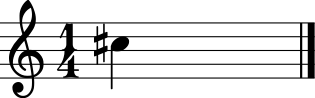

In [10]:
n = note.Note('C#5')
n.show()

In [11]:
n.show("midi")

In [ ]:
# !yes | add-apt-repository ppa:mscore-ubuntu/mscore3-stable
# !apt update
# !apt install musescore
# print("MuseScore installation finished")

# # !pip uninstall music21
# !pip install music21
# from music21 import note

In [ ]:
# !apt-get install musescore

In [12]:
file = "/content/mozart/mz_311_1.mid"
example_score = music21.converter.parse(file).chordify()

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


In [13]:
example_score

<music21.stream.Part 0x79389258ad70>

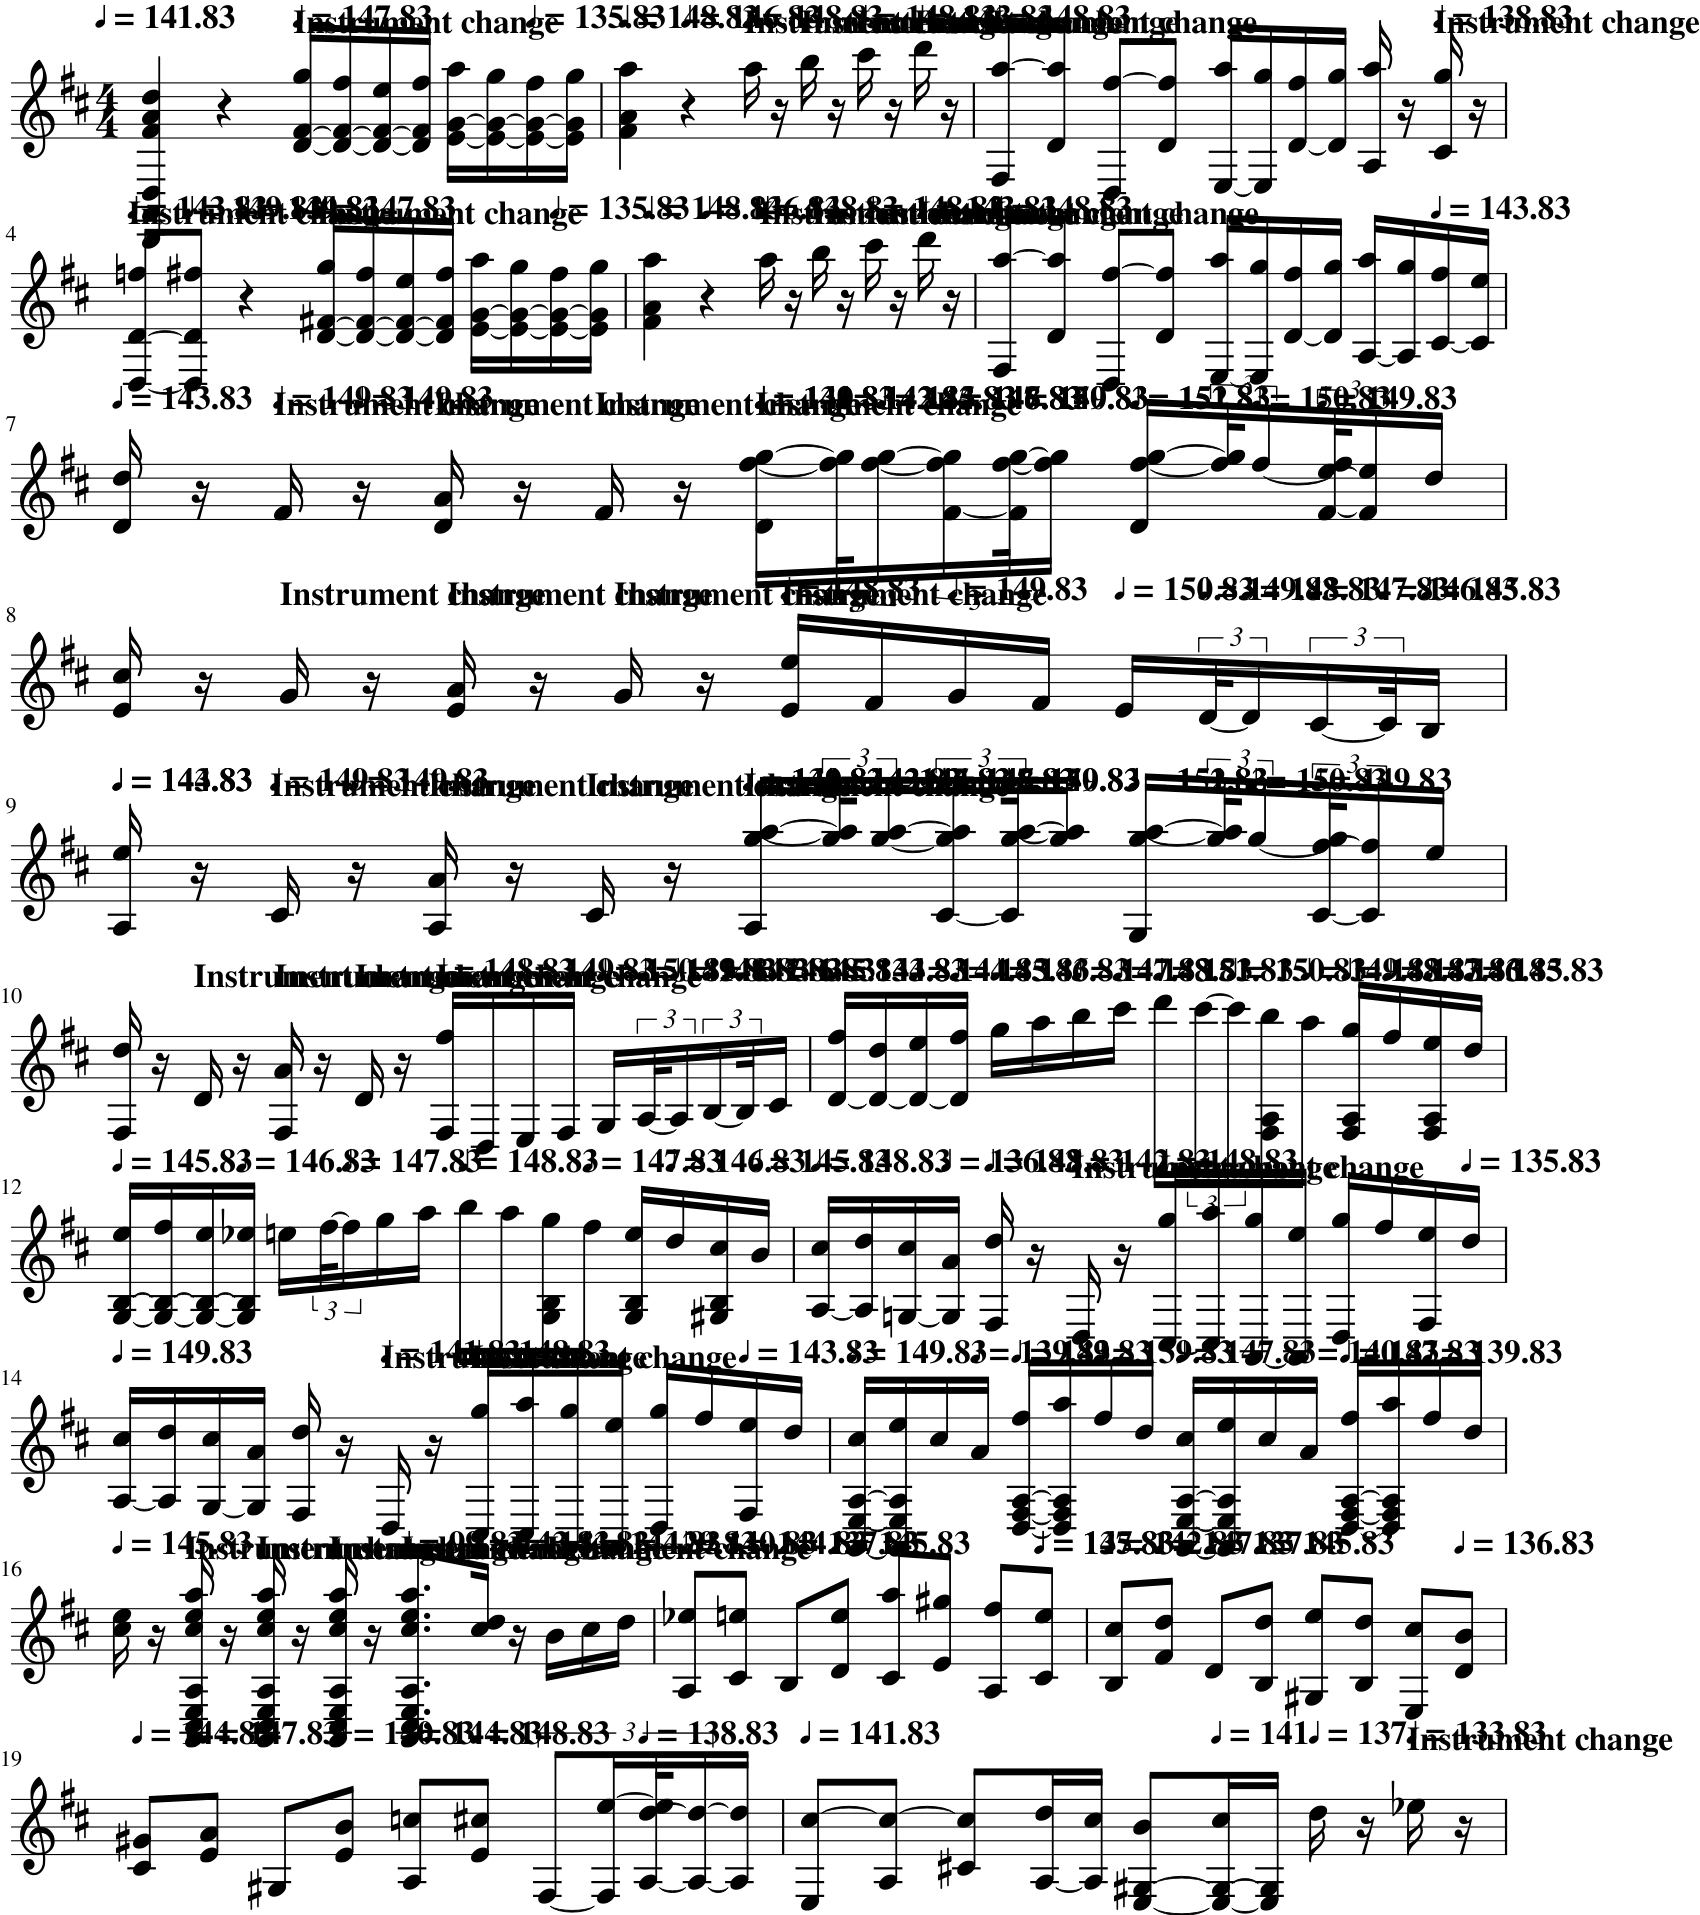

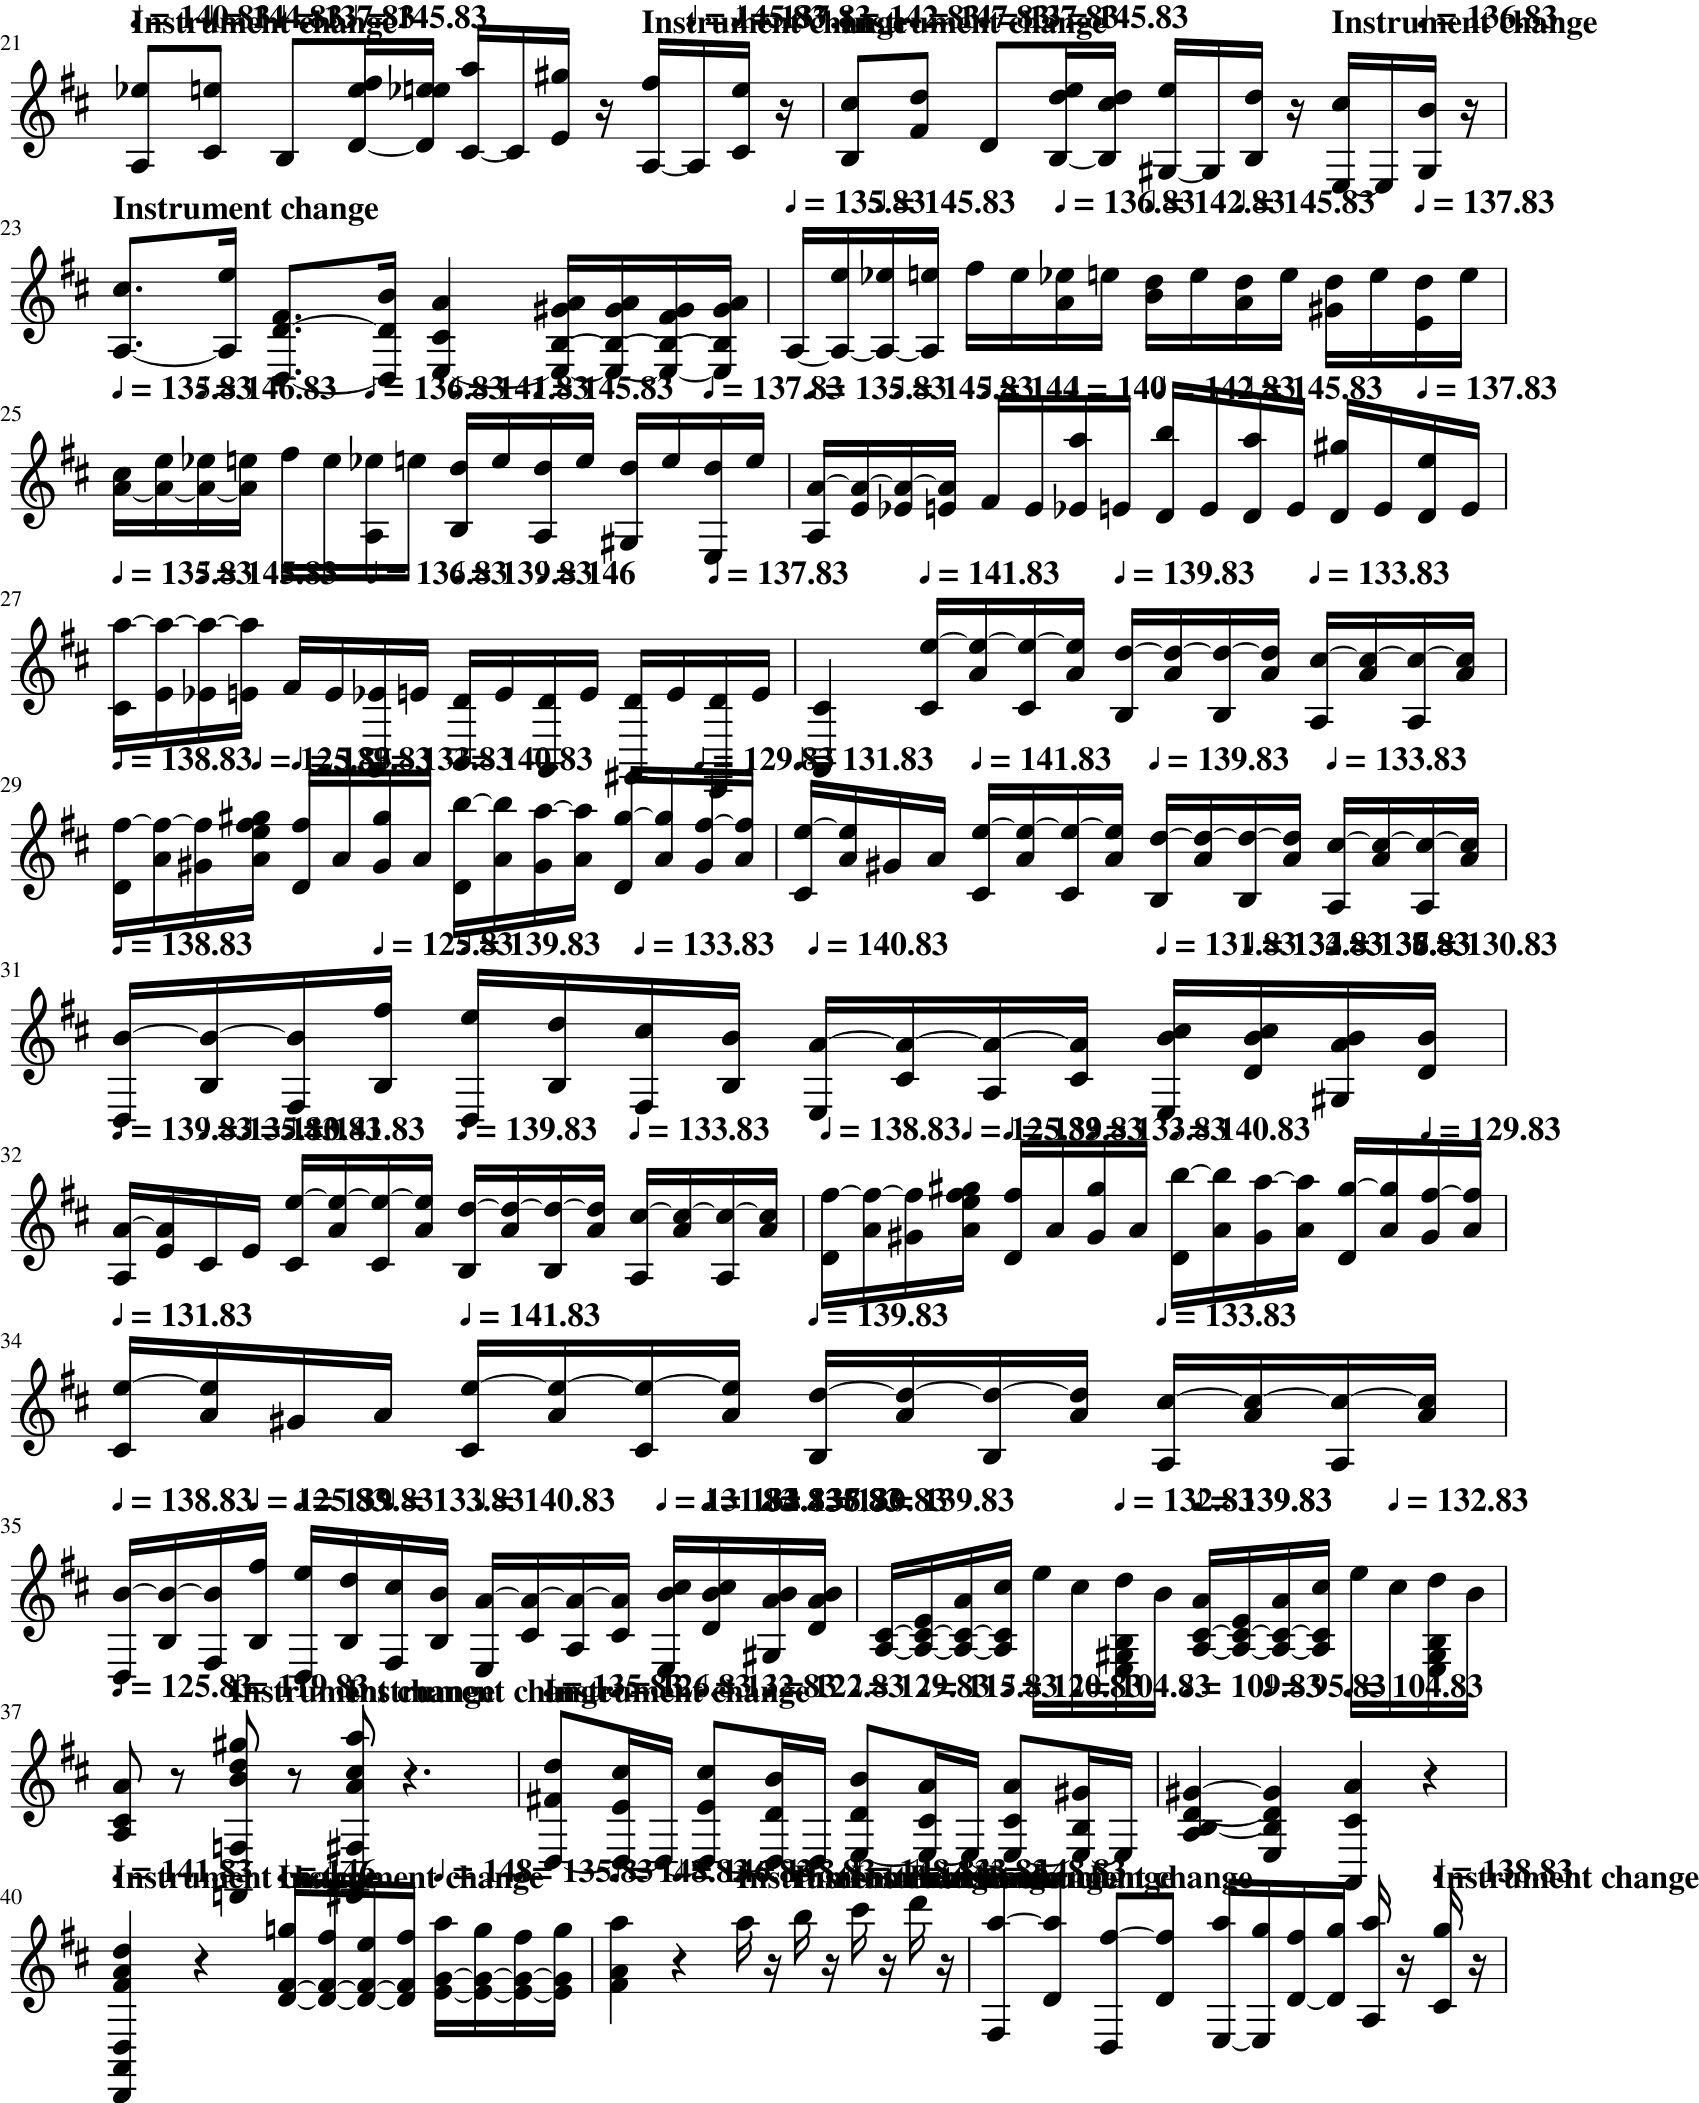

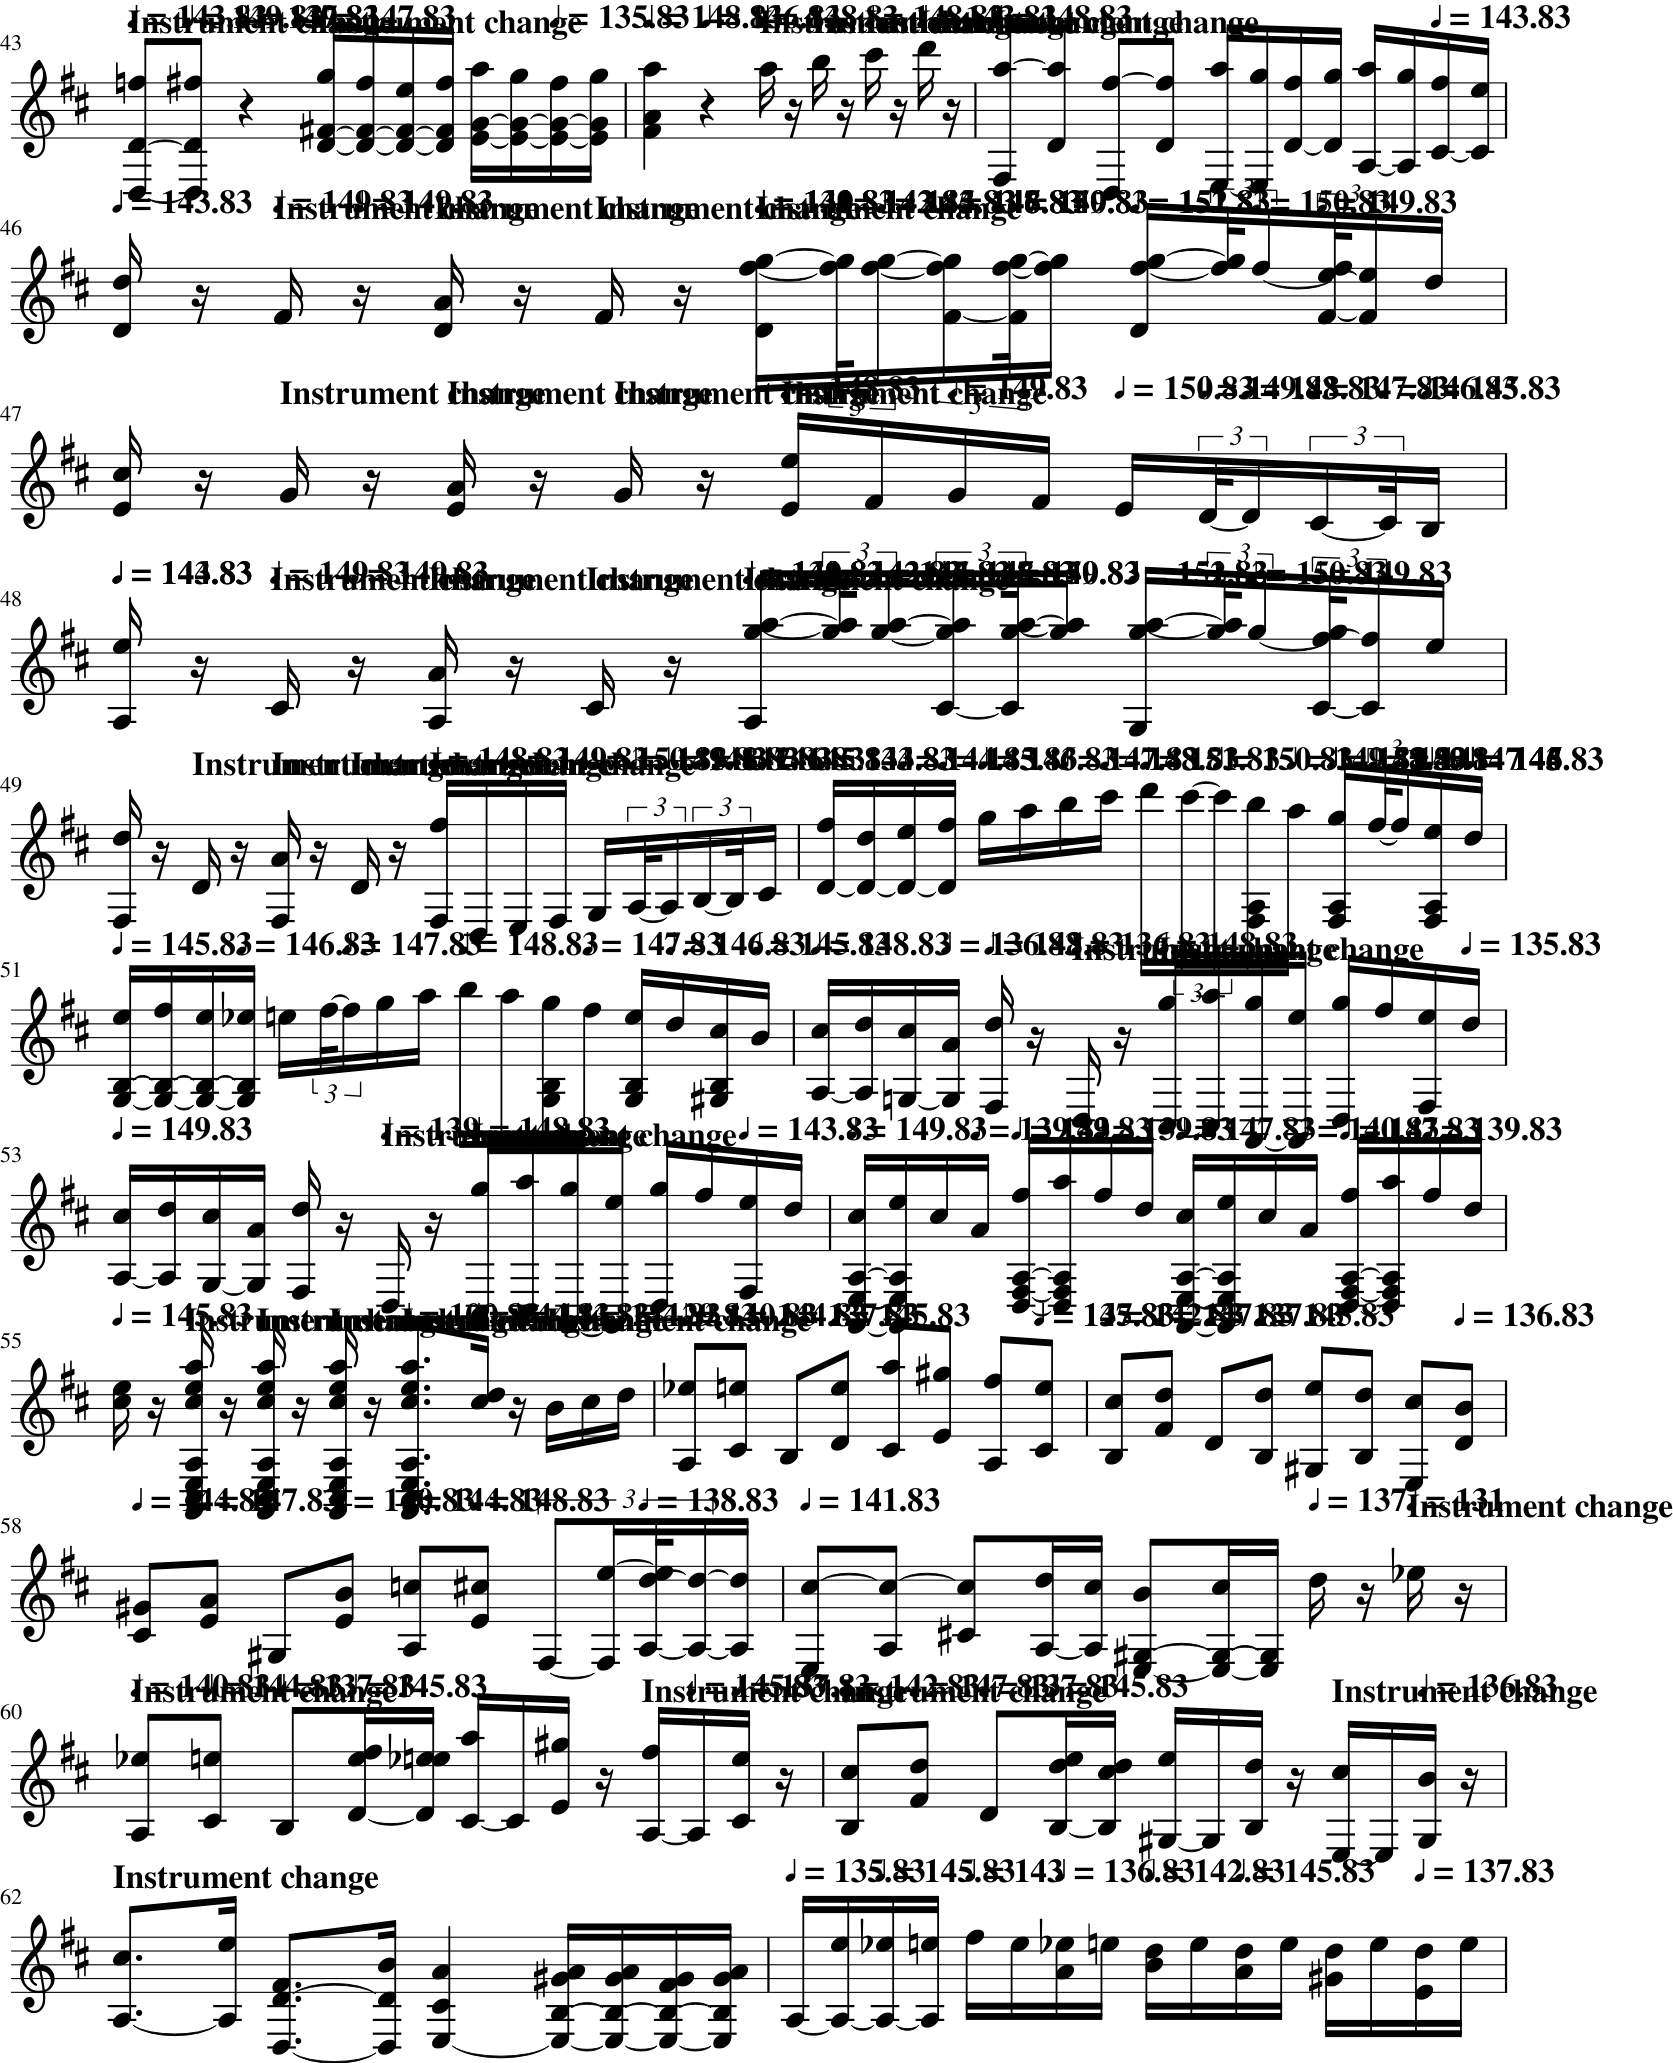

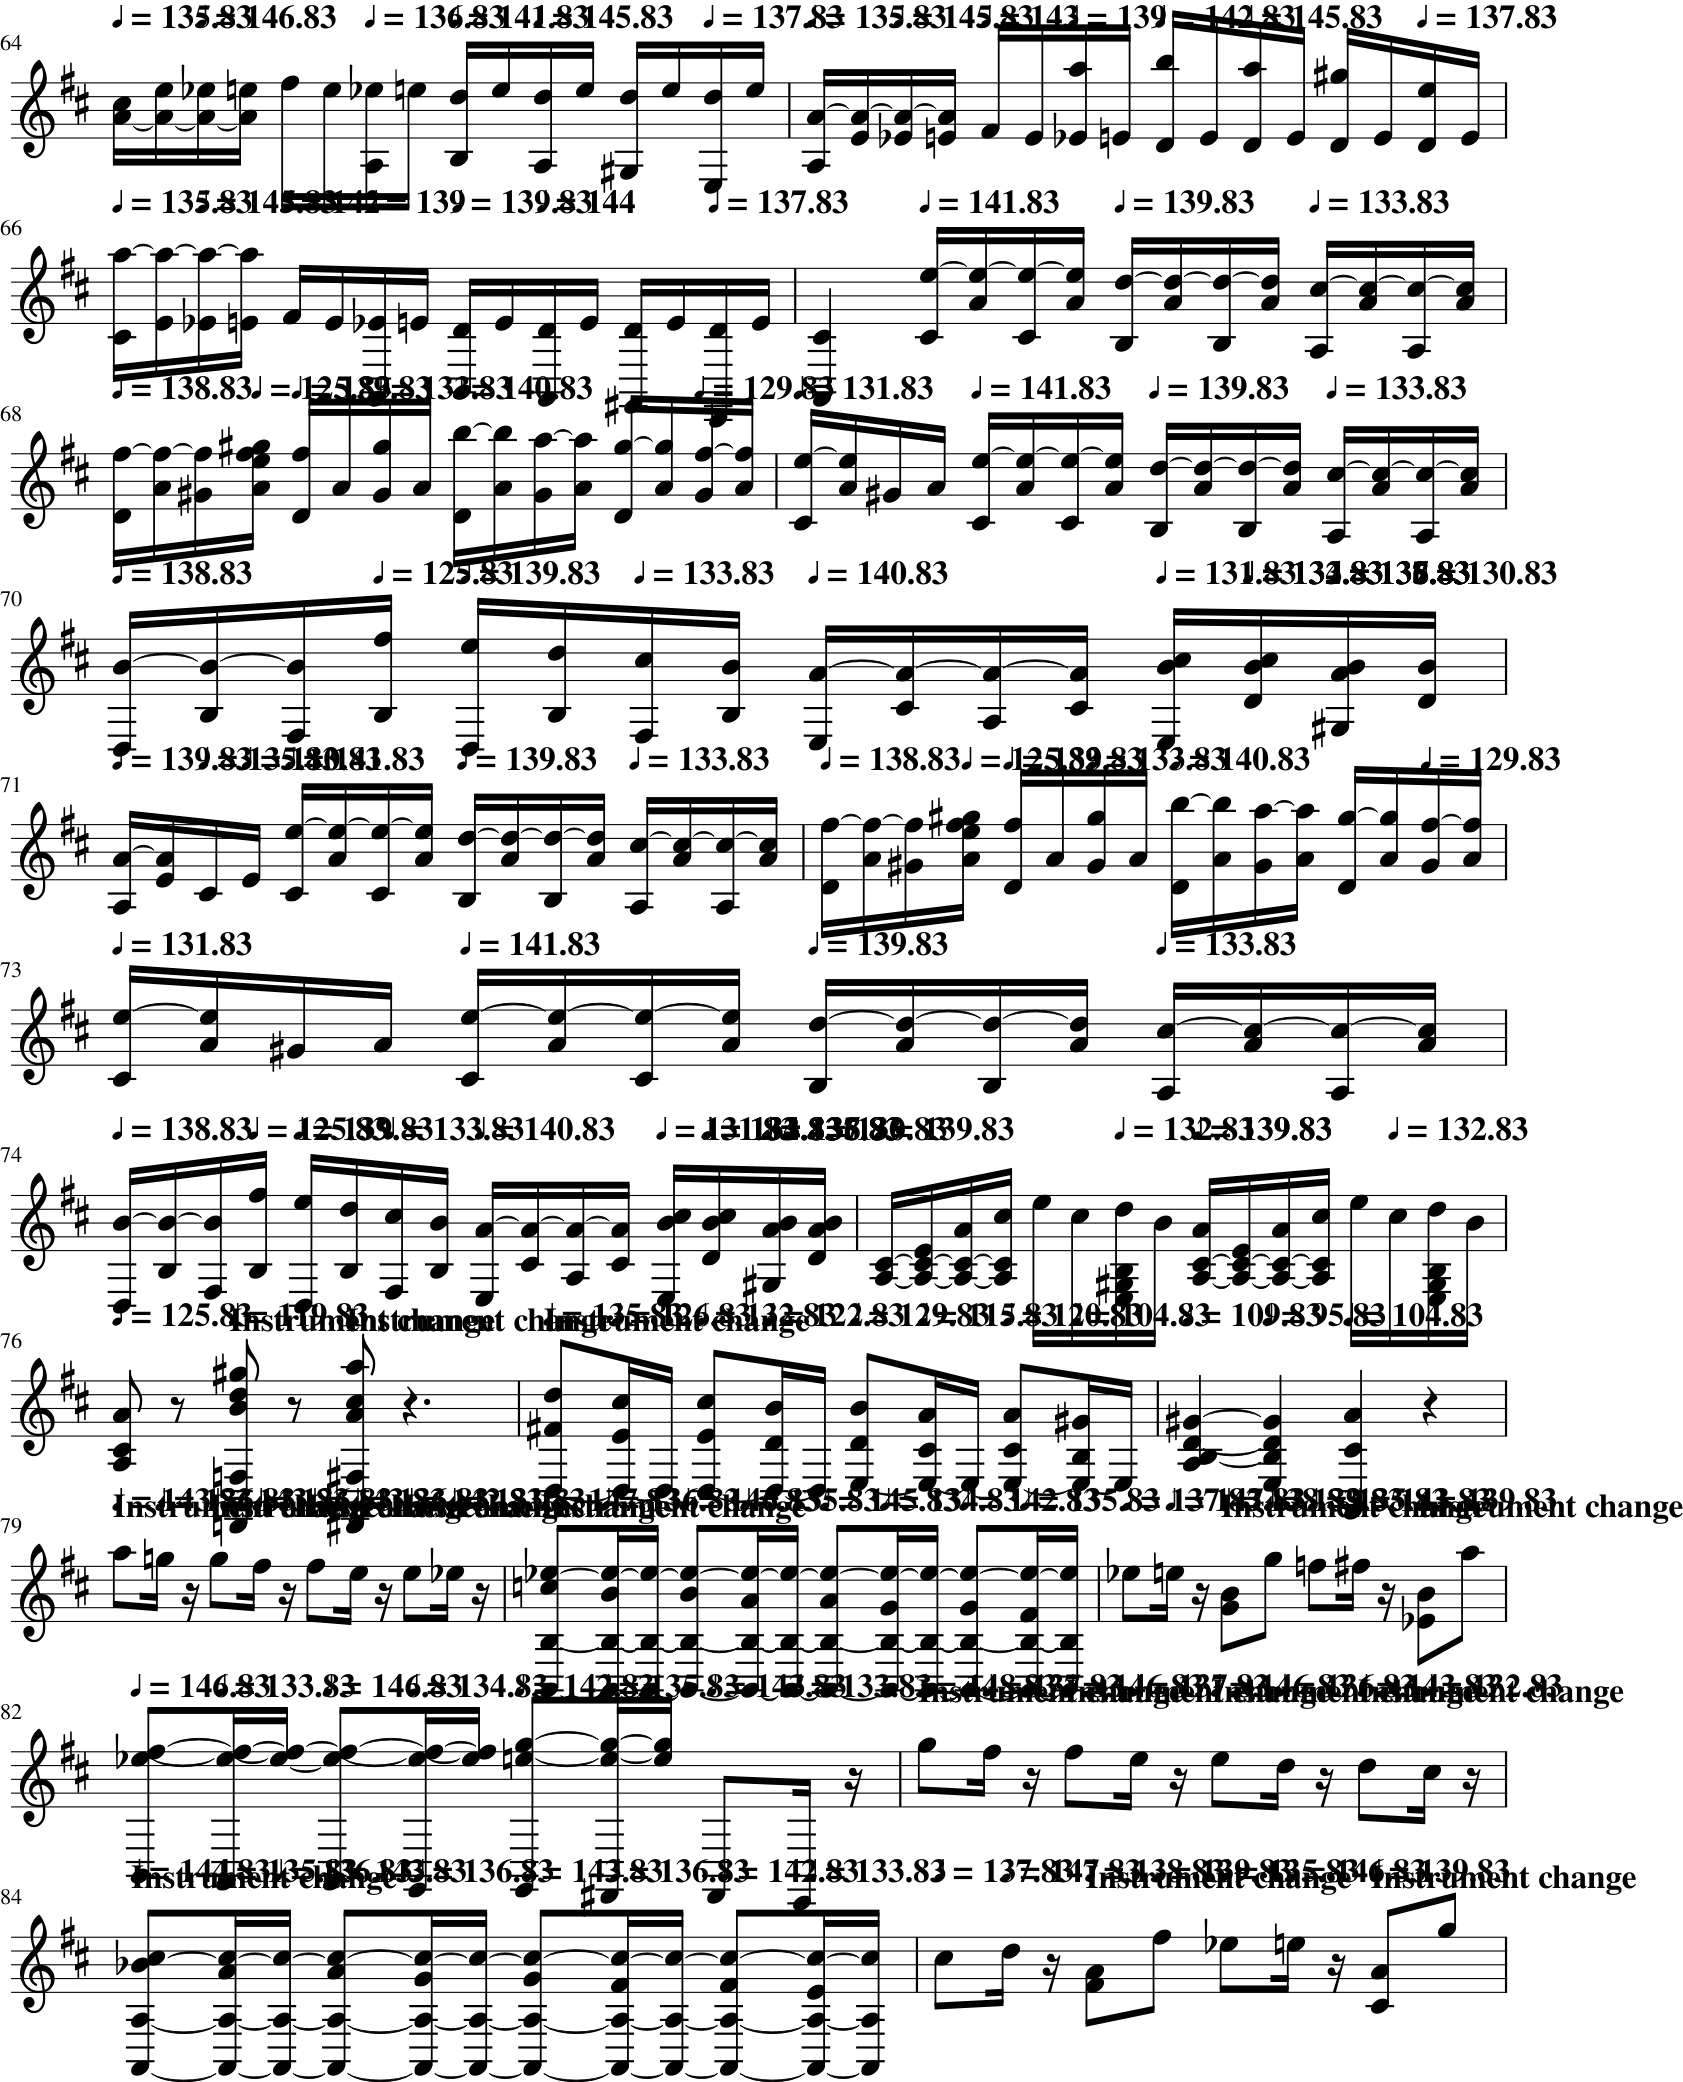

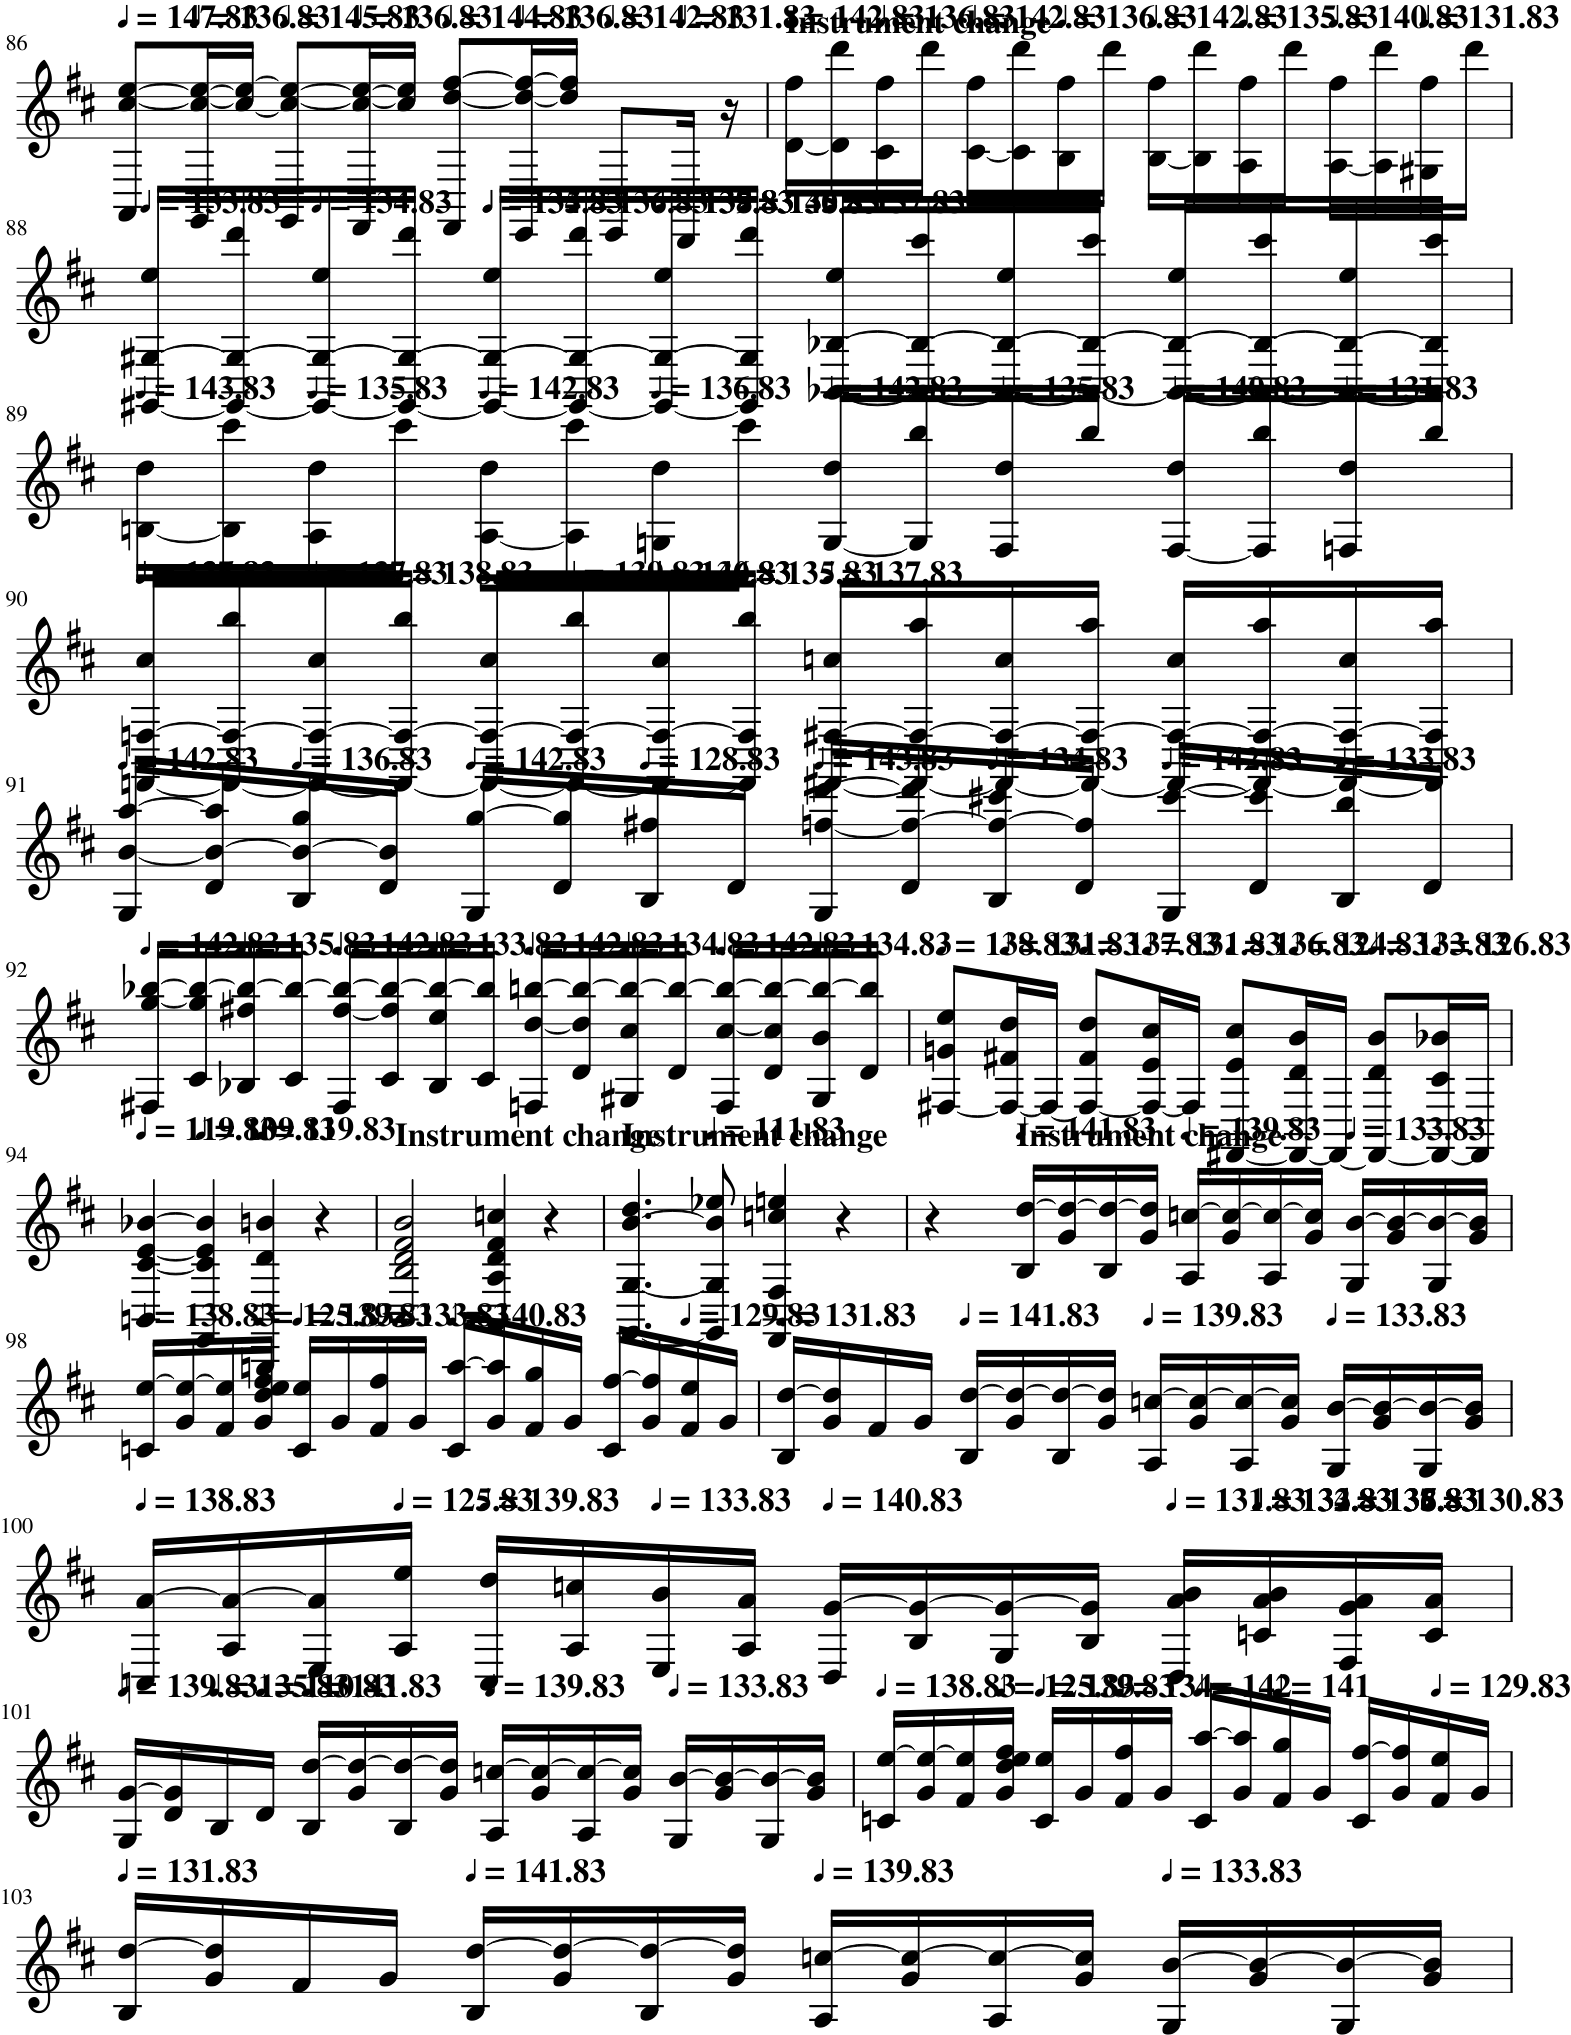

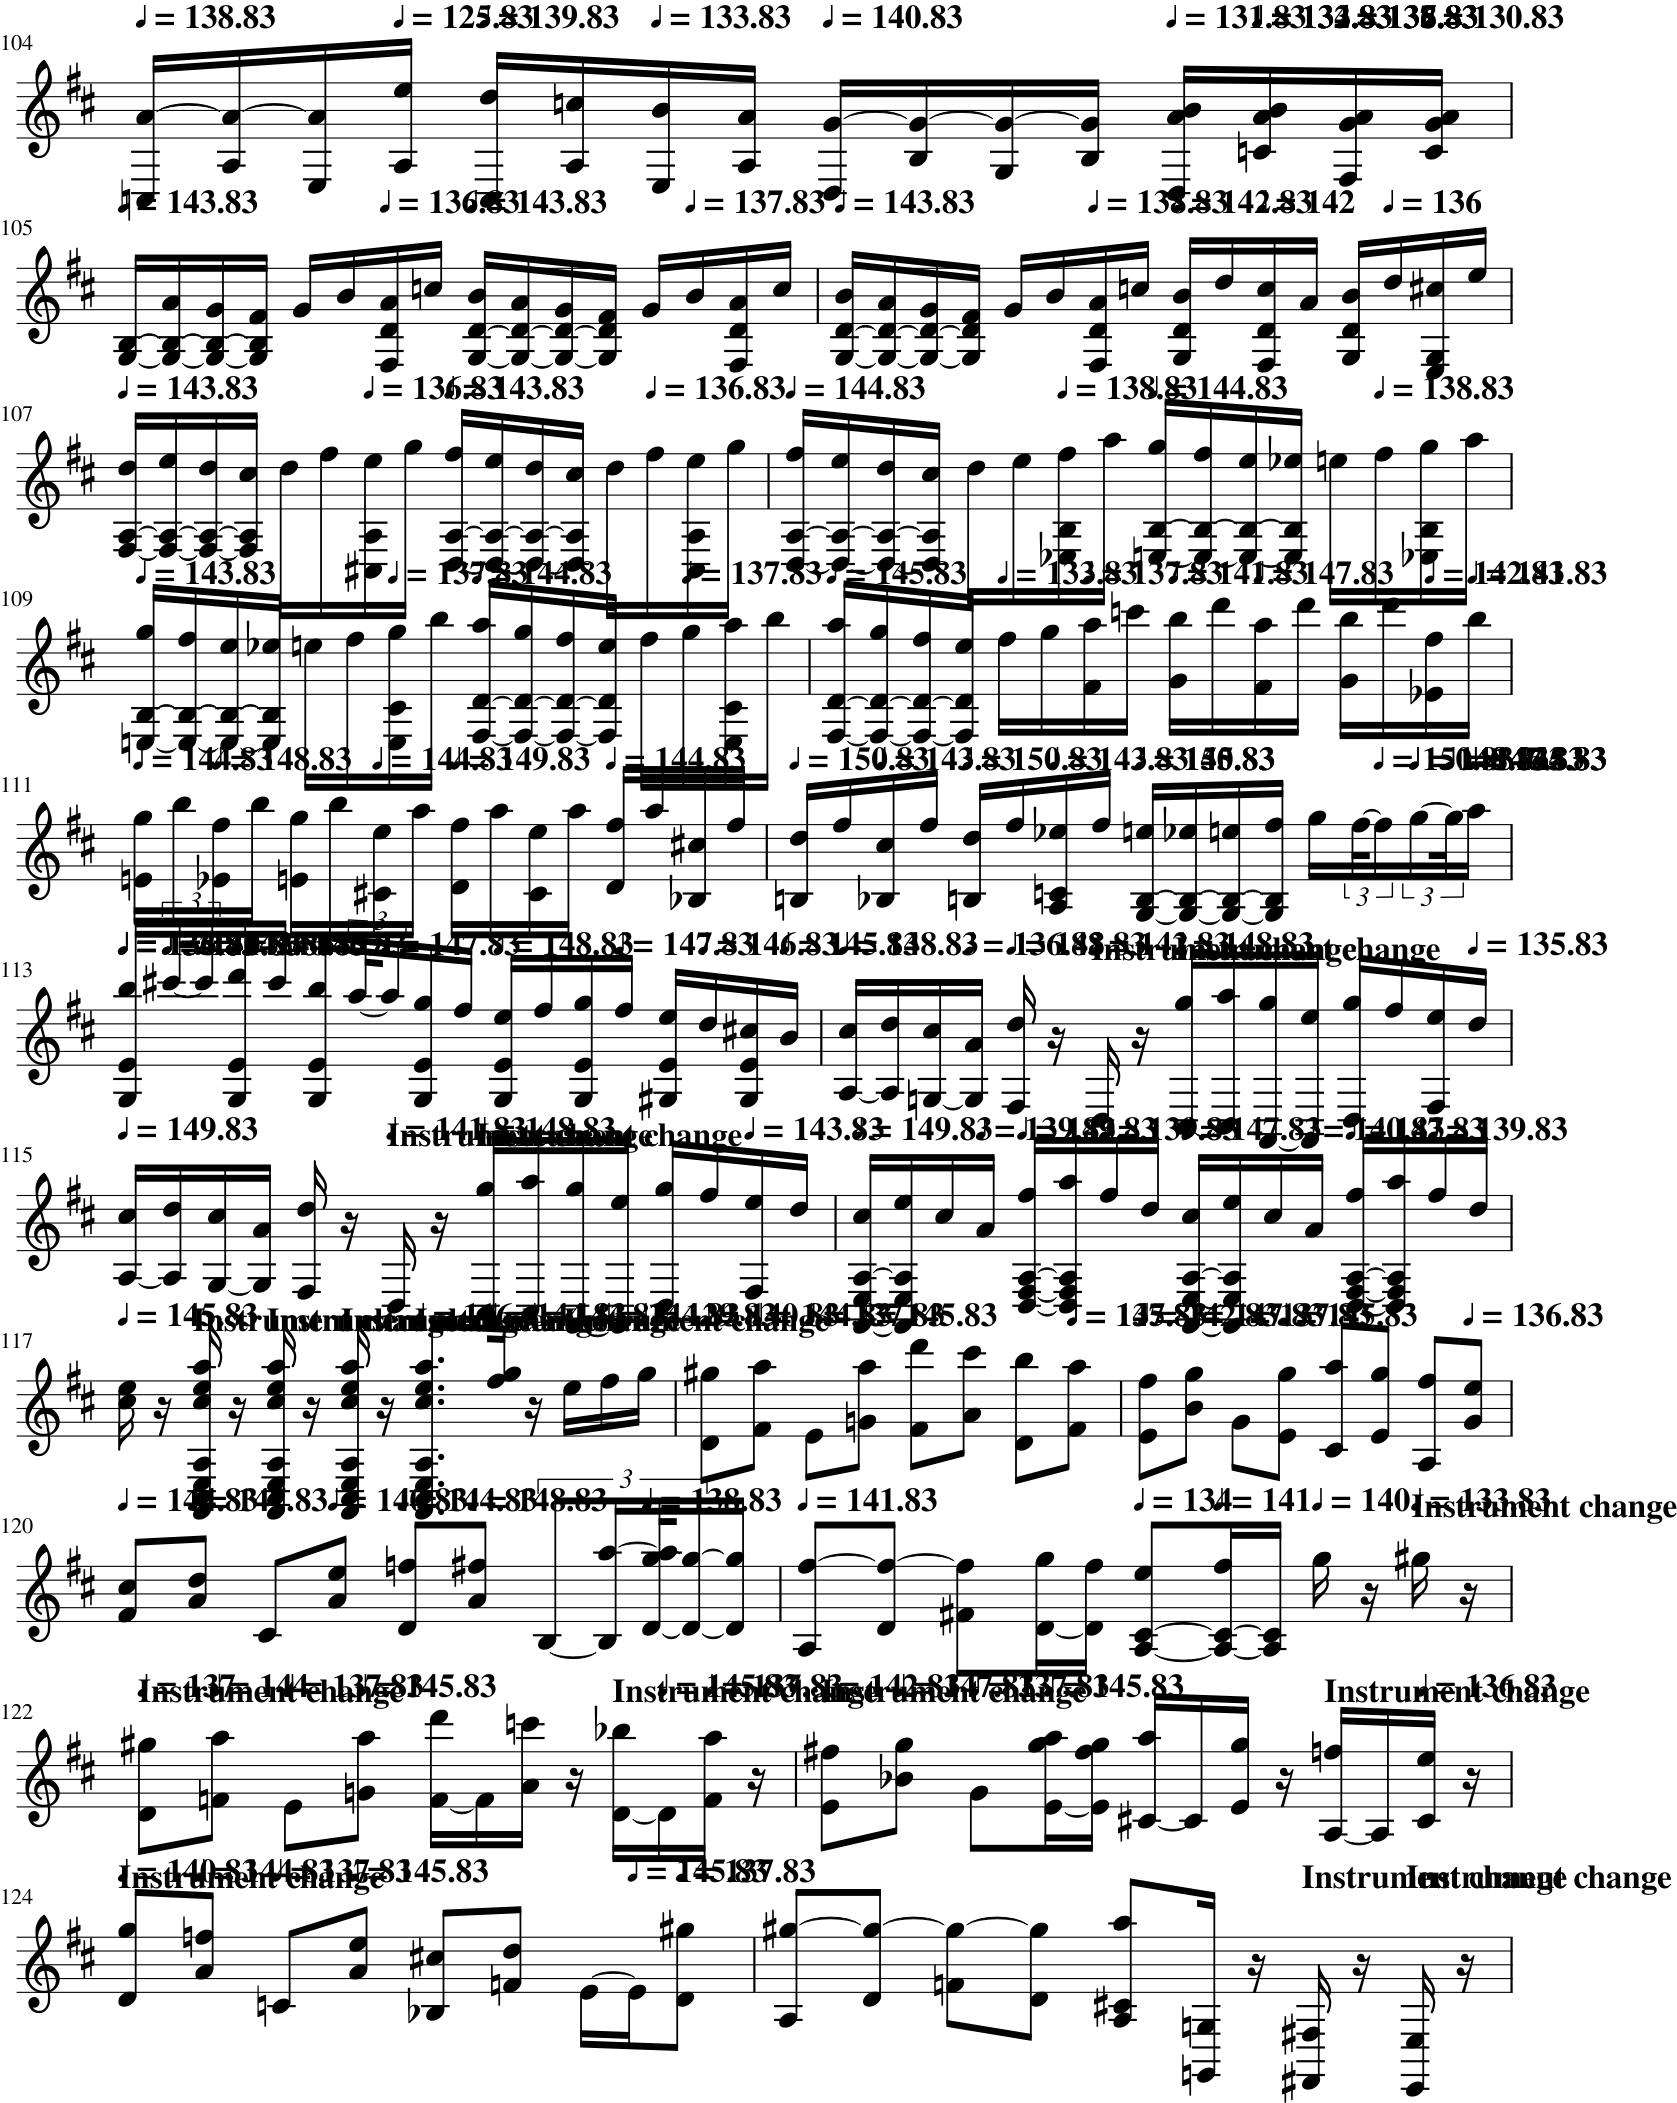

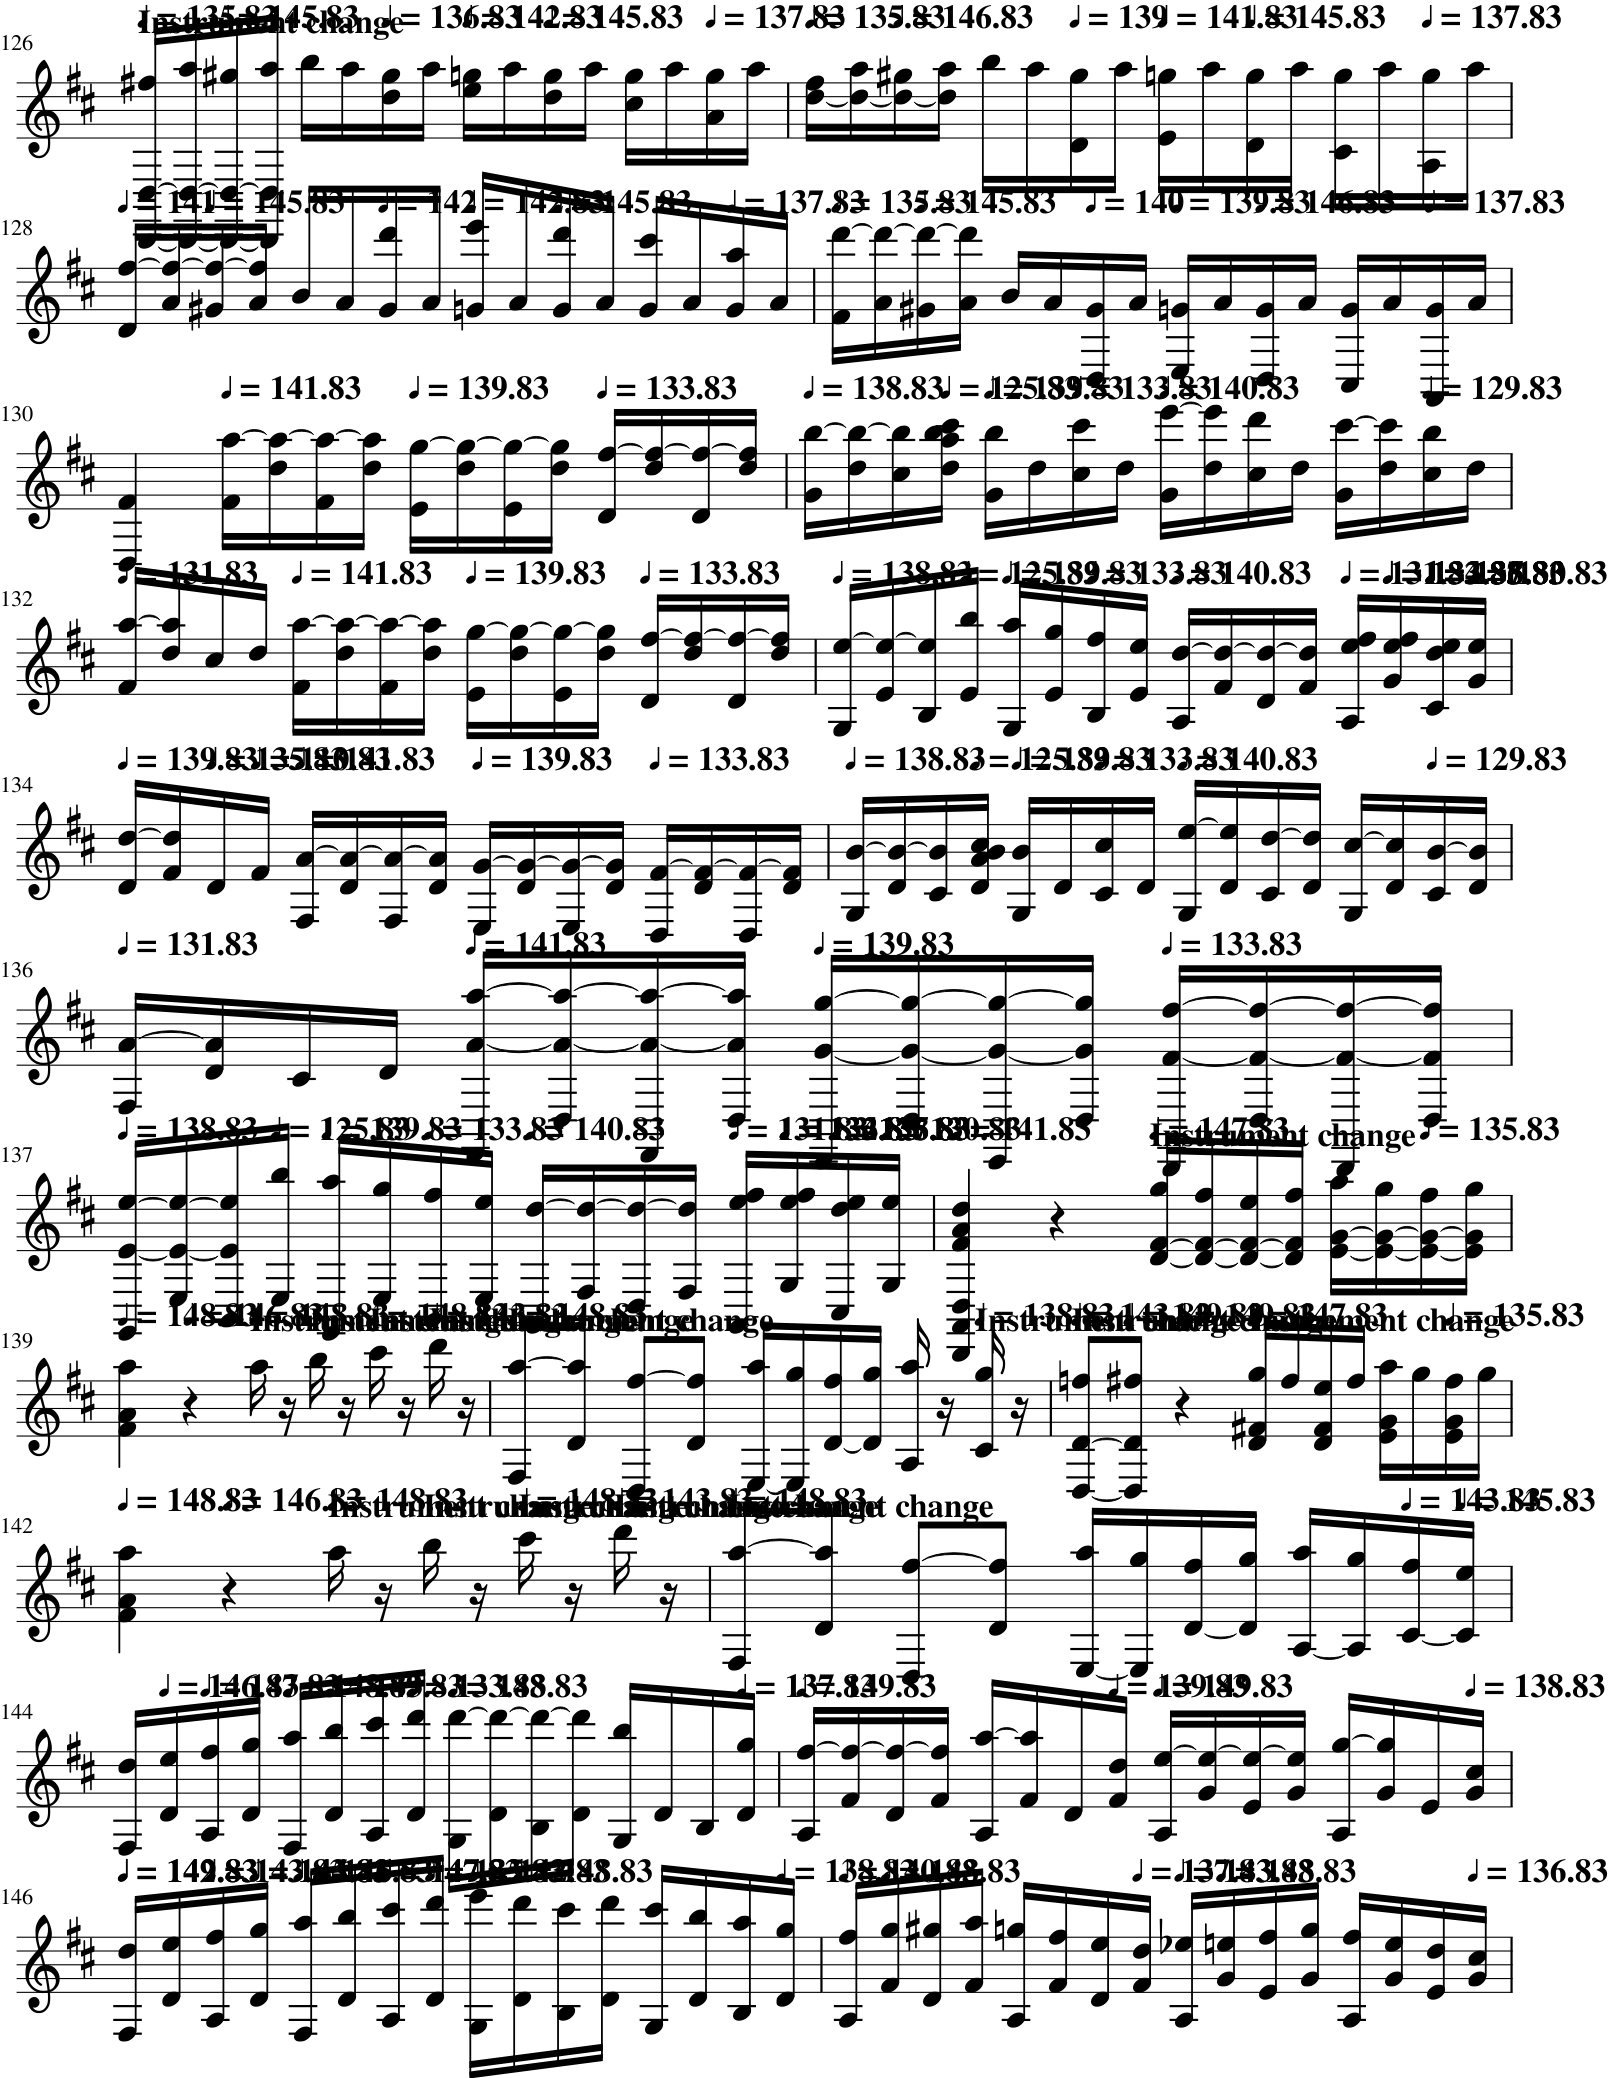

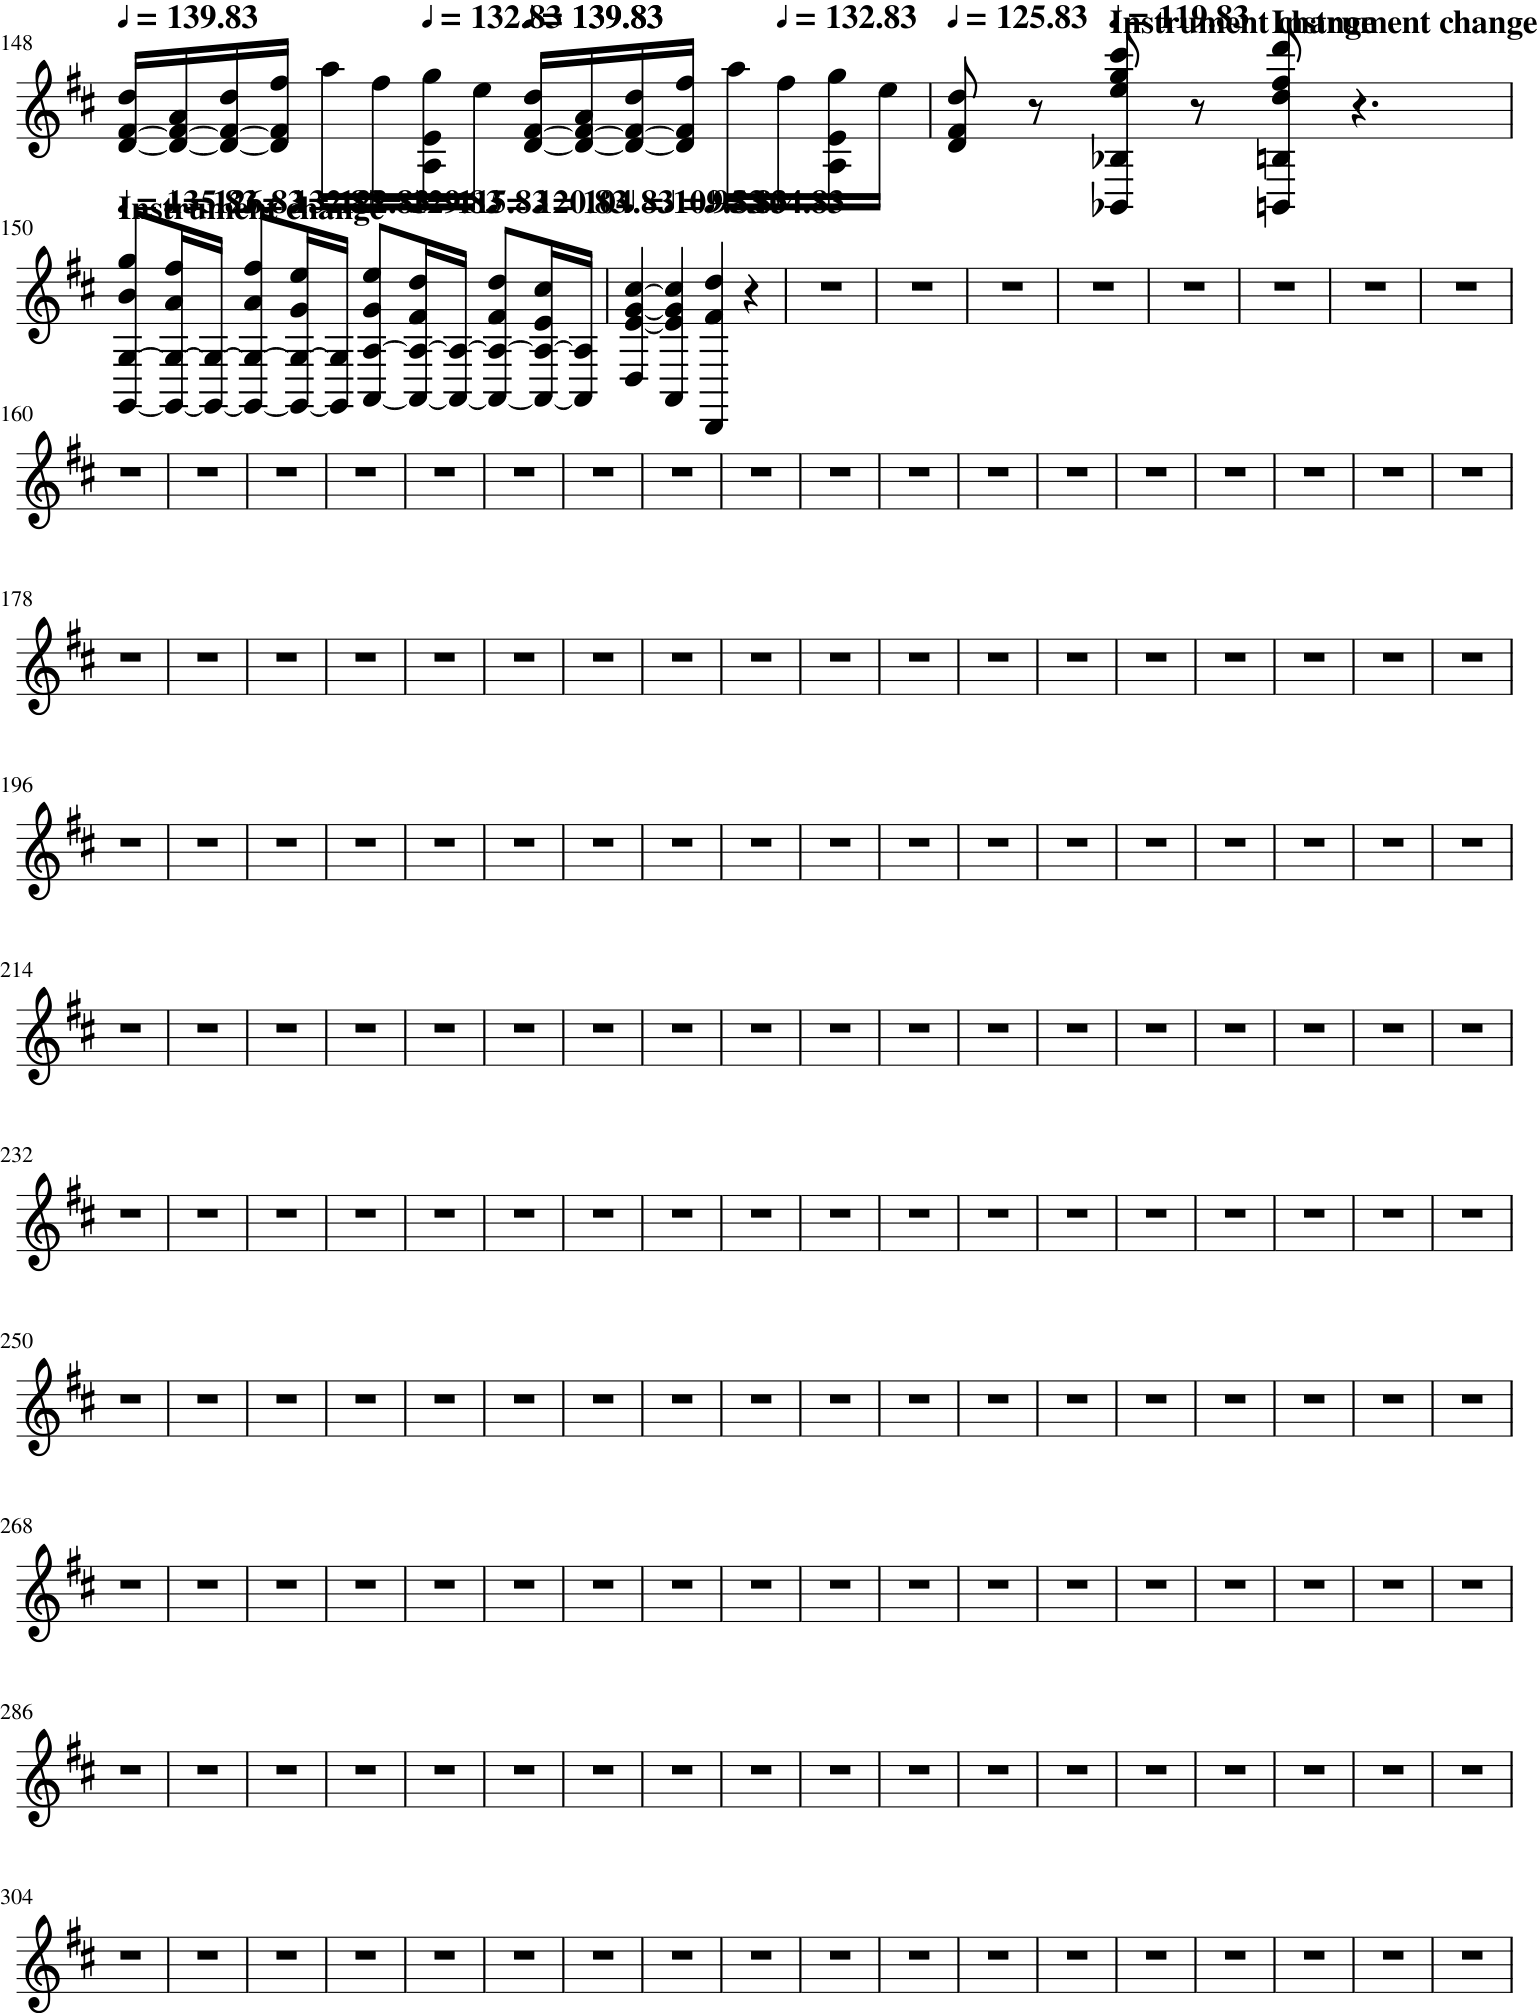

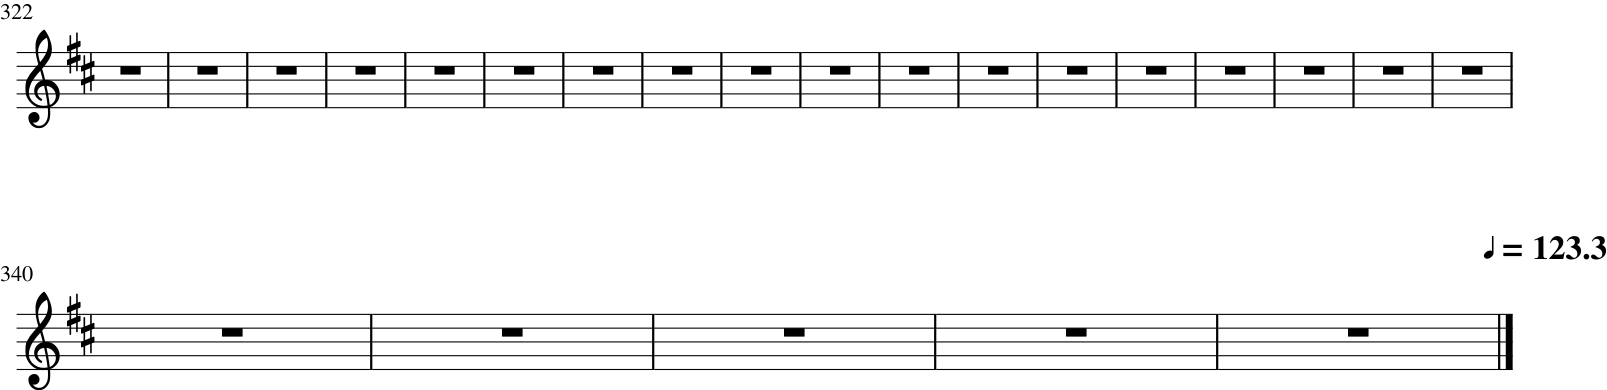

In [14]:
example_score.show()

In [16]:
example_score.show("midi")

In [23]:
# from IPython.display import Image, Audio

# def play(music):
#   filename = music.write('mid')
#   !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
#   display(Audio(filename + '.wav'))

In [72]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/content/mozart/"
DATASET_REPETITIONS = 1

SEQ_LEN = 70
EMBEDDING_DIM = 128
KEY_DIM = 128
N_HEADS = 3
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 128
LOAD_MODEL = False

# optimization
EPOCHS = 1000
BATCH_SIZE = 16

GENERATE_LEN = 70

In [16]:
file_list = glob.glob("/content/mozart/*.mid")
print(f"Found {len(file_list)} midi files")

Found 21 midi files


In [17]:
parser = music21.converter

In [18]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


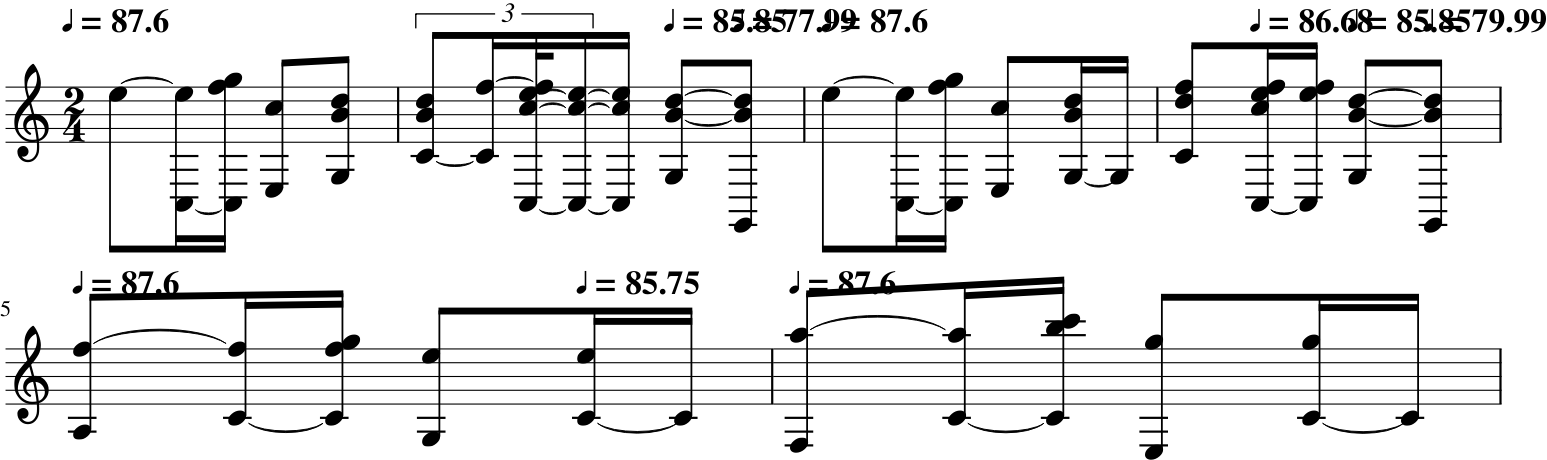

In [19]:
example_score.show()

In [20]:
example_score.show("midi")

In [21]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/mozart/mz_332_2.mid


<ipython-input-21-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


826 notes parsed
2 Parsing /content/mozart/mz_330_3.mid
3355 notes parsed
3 Parsing /content/mozart/mz_545_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


5576 notes parsed
4 Parsing /content/mozart/mz_545_3.mid
6210 notes parsed
5 Parsing /content/mozart/mz_570_1.mid
9281 notes parsed
6 Parsing /content/mozart/mz_331_2.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2005 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


10958 notes parsed
7 Parsing /content/mozart/mz_570_3.mid
12612 notes parsed
8 Parsing /content/mozart/mz_570_2.mid
13769 notes parsed
9 Parsing /content/mozart/mz_311_1.mid
16025 notes parsed
10 Parsing /content/mozart/mz_333_1.mid
20435 notes parsed
11 Parsing /content/mozart/mz_333_3.mid
23043 notes parsed
12 Parsing /content/mozart/mz_311_3.mid
25772 notes parsed
13 Parsing /content/mozart/mz_333_2.mid
27330 notes parsed
14 Parsing /content/mozart/mz_332_1.mid
30507 notes parsed
15 Parsing /content/mozart/mz_545_2.mid
31979 notes parsed
16 Parsing /content/mozart/mz_332_3.mid
36472 notes parsed
17 Parsing /content/mozart/mz_331_1.mid
39913 notes parsed
18 Parsing /content/mozart/mz_311_2.mid
41290 notes parsed
19 Parsing /content/mozart/mz_330_2.mid
42105 notes parsed
20 Parsing /content/mozart/mz_331_3.mid
43796 notes parsed
21 Parsing /content/mozart/mz_330_1.mid
46517 notes parsed
Building sequences of length 51


In [22]:
len(notes)

46466

In [23]:
example_notes = notes[1000]
example_durations = durations[1000]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 D5 F#4 G4 F5 F5 F5 F5 G5 F5 A5 G5 F5 E5 D5 C5 B4 C5 D5 E5 F5 G5 A5 B5 C6 D6 E6 F6 E-6 E-6 E-6 E-6 E6 E6 E4 E4 G4 E5 E5 E5 E5 C6 E6 C6 A5 D5 D5 D5 D5 B5 D6 B5 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 1/6 1/12 0.25 1/3 1/6 1/12 1/12 1/3 1/3 1/3 1/3 1/3 1/6 1/12 1/12 1/3 1/3 1/3 ...


## Tokenize the Data

In [73]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [74]:
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         2         2
        29         2
        12         2
         6         2
         6         2
         6         2
         6         2
         3         2
         6         2
         8         2
         3         2


In [75]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 77
0: 
1: [UNK]
2: D5
3: G5
4: rest
5: C5
6: F5
7: E5
8: A5
9: A4

DURATIONS_VOCAB: length = 25
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1/6
5: 1/12
6: 1.0
7: 1/3
8: 2.0
9: 0.75


## Training Set

In [76]:
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [77]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(16, 50), dtype=int64, numpy=
array([[ 6,  2,  5,  6, 13,  2, 47, 30,  4, 15, 15,  3,  3, 18, 18, 26,
        26, 26, 33, 16, 16, 18, 18,  8,  8,  9,  9,  5,  5, 13, 13, 15,
        15, 15, 23,  6,  6, 13, 13,  2,  2, 10,  4,  5,  4,  2,  4, 13,
         4,  7],
       [ 2,  5,  6, 13,  2, 47, 30,  4, 15, 15,  3,  3, 18, 18, 26, 26,
        26, 33, 16, 16, 18, 18,  8,  8,  9,  9,  5,  5, 13, 13, 15, 15,
        15, 23,  6,  6, 13, 13,  2,  2, 10,  4,  5,  4,  2,  4, 13,  4,
         7,  4],
       [ 5,  6, 13,  2, 47, 30,  4, 15, 15,  3,  3, 18, 18, 26, 26, 26,
        33, 16, 16, 18, 18,  8,  8,  9,  9,  5,  5, 13, 13, 15, 15, 15,
        23,  6,  6, 13, 13,  2,  2, 10,  4,  5,  4,  2,  4, 13,  4,  7,
         4,  6],
       [ 6, 13,  2, 47, 30,  4, 15, 15,  3,  3, 18, 18, 26, 26, 26, 33,
        16, 16, 18, 18,  8,  8,  9,  9,  5,  5, 13, 13, 15, 15, 15, 23,
         6,  6, 13, 13,  2,  2, 10,  4,  5,  4,  2,  4, 13,  4,  7,  4,
         6,  4],
       [13,  2, 47

## Masking

In [78]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [79]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

In [80]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

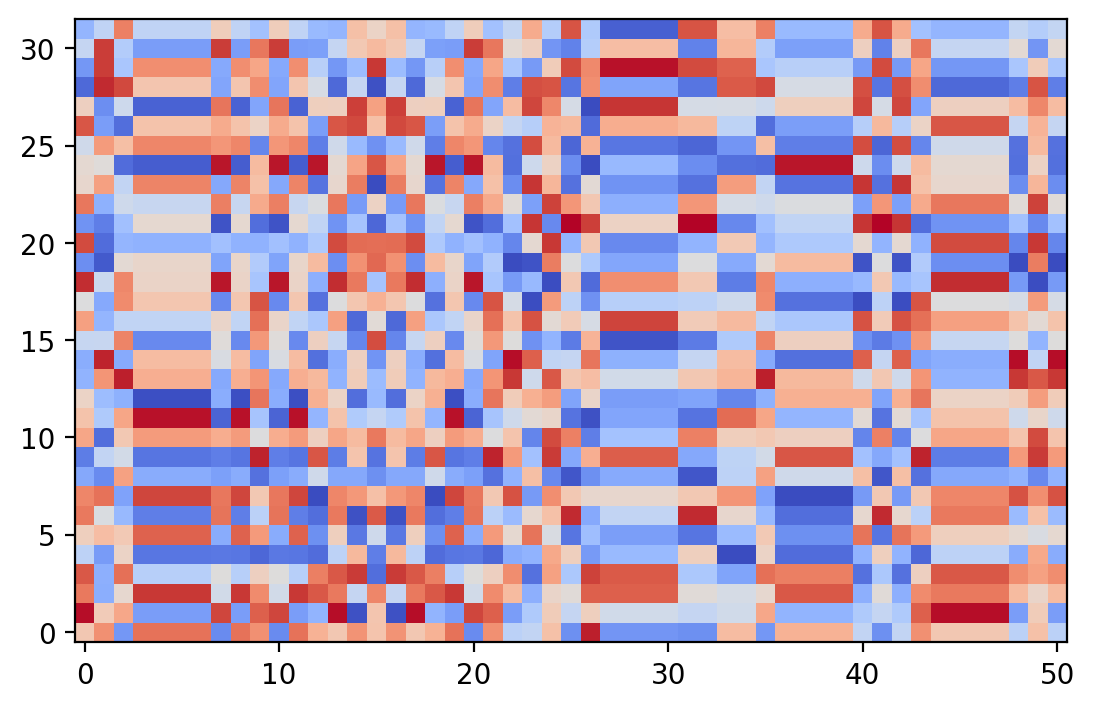

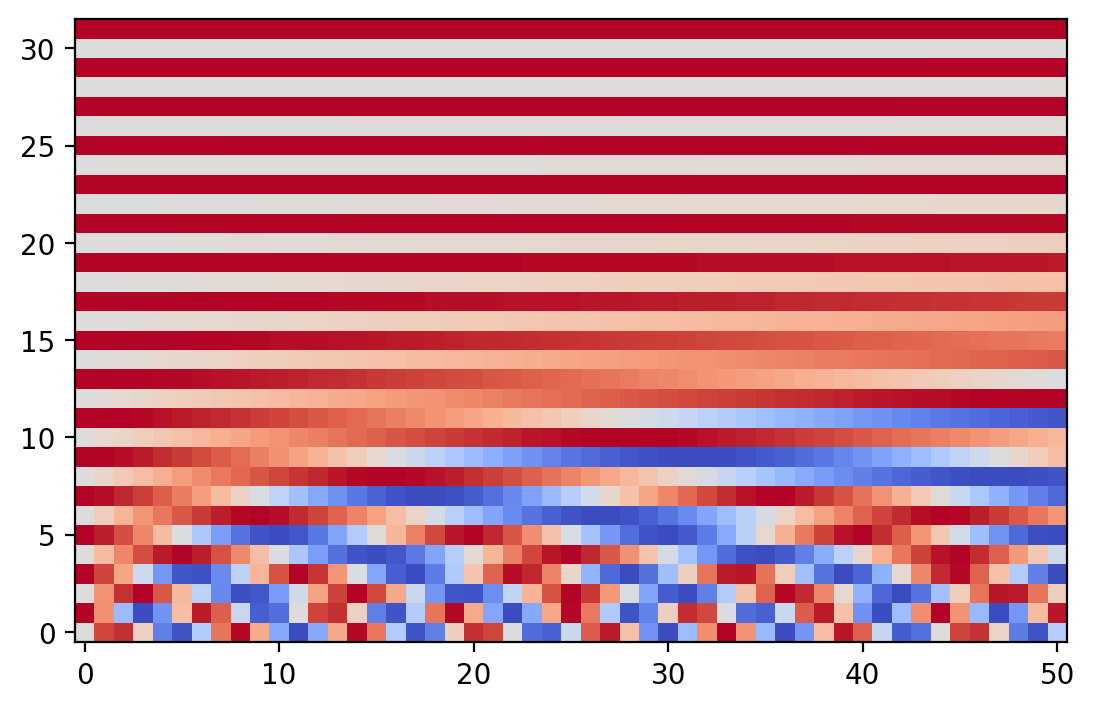

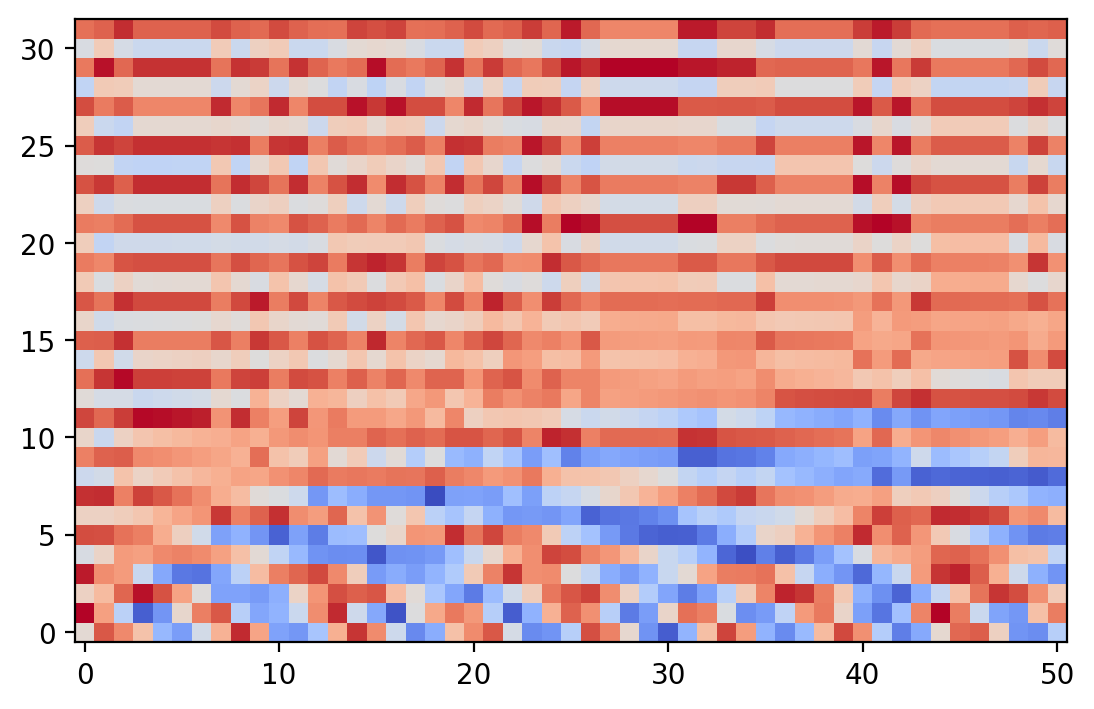

In [81]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## Transformer

In [82]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [83]:
model.summary()

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 token_and_position_embeddi  (None, None, 64)             4928      ['input_3[0][0]']             
 ng_4 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                           

In [35]:
!mkdir output

## Training

In [123]:
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.TrebleClef()) # can also base clef

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.75
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.show("midi")

        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [124]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

Epoch 1/50
   6/2904 [..............................] - ETA: 33s - loss: 2.3776 - note_outputs_loss: 1.8759 - duration_outputs_loss: 0.5017 

2903/2904 [============================>.] - ETA: 0s - loss: 2.7447 - note_outputs_loss: 2.1484 - duration_outputs_loss: 0.5963[['START', '3/4TS', 'E4', 'E4', 'E4', 'E4', 'D4', 'E4', 'E4', 'A4', 'E4', 'C#5', 'B4', 'E4', 'E4', 'A4', 'A4', 'A4', 'A4', 'A4', 'B4', 'B4', 'B4', 'B4', 'B4', 'C#5', 'E4', 'C#5', 'D5', 'E5', 'D5', 'C#5', 'B4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'G#4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'B4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '1/6', '1/12', '1/6', '1/6', '1/12', '1/6', '1/6', '1/12', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '1/12', '1/6', '1/6', '1/12', '1/6', '1/6', '1/12', '1/6', '0.25', '1/12', '1/6', '

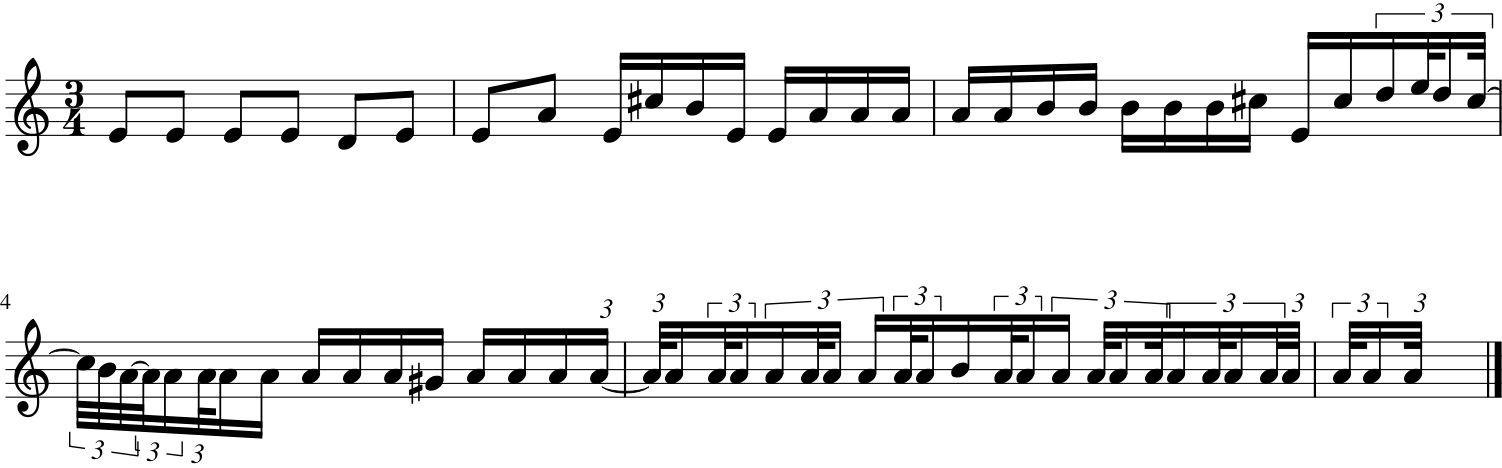

2904/2904 [==============================] - 44s 15ms/step - loss: 2.7446 - note_outputs_loss: 2.1484 - duration_outputs_loss: 0.5962
Epoch 2/50
2901/2904 [============================>.] - ETA: 0s - loss: 2.7246 - note_outputs_loss: 2.1289 - duration_outputs_loss: 0.5957[['START', '3/4TS', 'rest', 'A4', 'C5', 'C5', 'B4', 'C5', 'B4', 'C5', 'B4', 'A4', 'B4', 'C5', 'C5', 'C5', 'B4', 'A4', 'C5', 'C5', 'C5', 'C5', 'A4', 'C5', 'B4', 'C5', 'C5', 'B4', 'C5', 'F5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'G4', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5'], ['0.0', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25

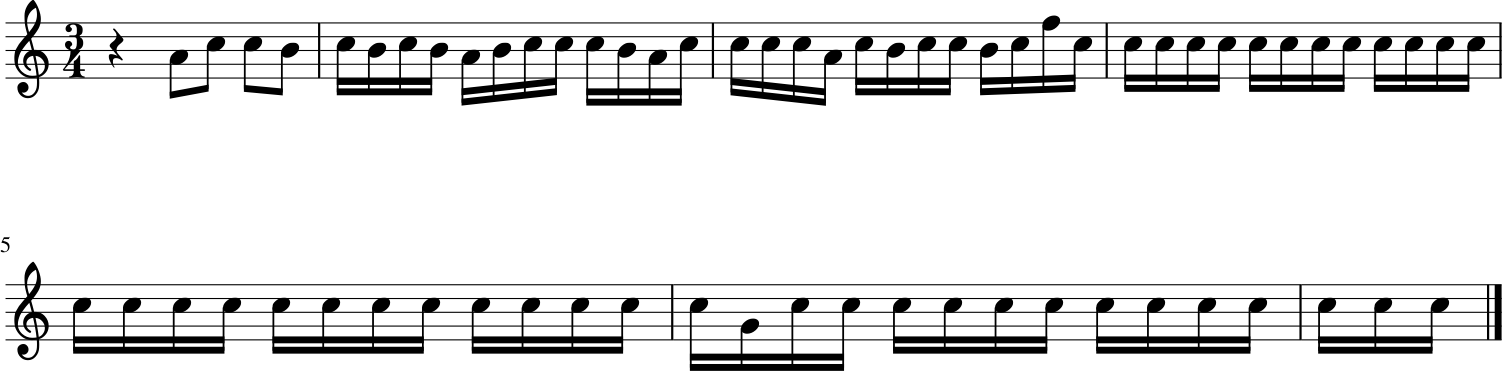

2904/2904 [==============================] - 48s 17ms/step - loss: 2.7245 - note_outputs_loss: 2.1285 - duration_outputs_loss: 0.5960
Epoch 3/50
2902/2904 [============================>.] - ETA: 0s - loss: 2.7017 - note_outputs_loss: 2.1065 - duration_outputs_loss: 0.5952[['START', '3/4TS', 'B4', 'B4', 'B4', 'A4', 'G4', 'F#4', 'G4', 'B4', 'A4', 'A4', 'A4', 'B4', 'B4', 'B4', 'G4', 'G4', 'G4', 'G4', 'A4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0

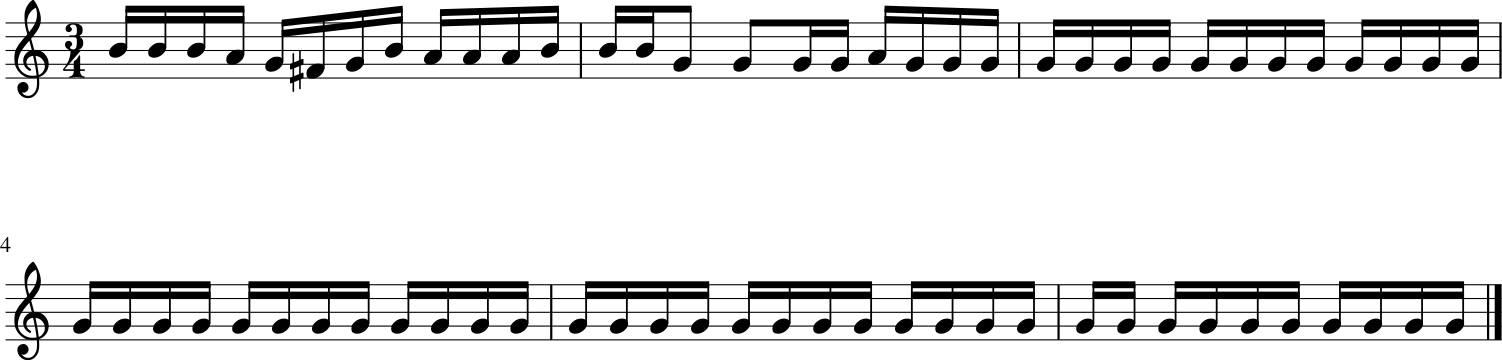

2904/2904 [==============================] - 44s 15ms/step - loss: 2.7014 - note_outputs_loss: 2.1063 - duration_outputs_loss: 0.5951
Epoch 4/50
2901/2904 [============================>.] - ETA: 0s - loss: 2.6851 - note_outputs_loss: 2.0898 - duration_outputs_loss: 0.5953[['START', '3/4TS', 'F4', 'A4', 'A4', 'B-4', 'C5', 'E4', 'F4', 'G4', 'A4', 'C5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'G5', 'F5', 'E-5', 'E-5', 'C5', 'B-4', 'A4', 'G4', 'F4', 'F4', 'F4', 'F4', 'E4', 'D4', 'C5', 'D4', 'B4', 'C4', 'B4', 'C5', 'D5', 'D5', 'D5', 'C5', 'B-4', 'A4', 'G4', 'F4', 'G4', 'A4', 'A4', 'C5', 'C5', 'C5', 'B-4', 'G4', 'G4', 'B-4', 'C5', 'C5', 'G4', 'E-4', 'C5', 'G4', 'F4', 'C5', 'B-4', 'G4', 'A4', 'C5'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '

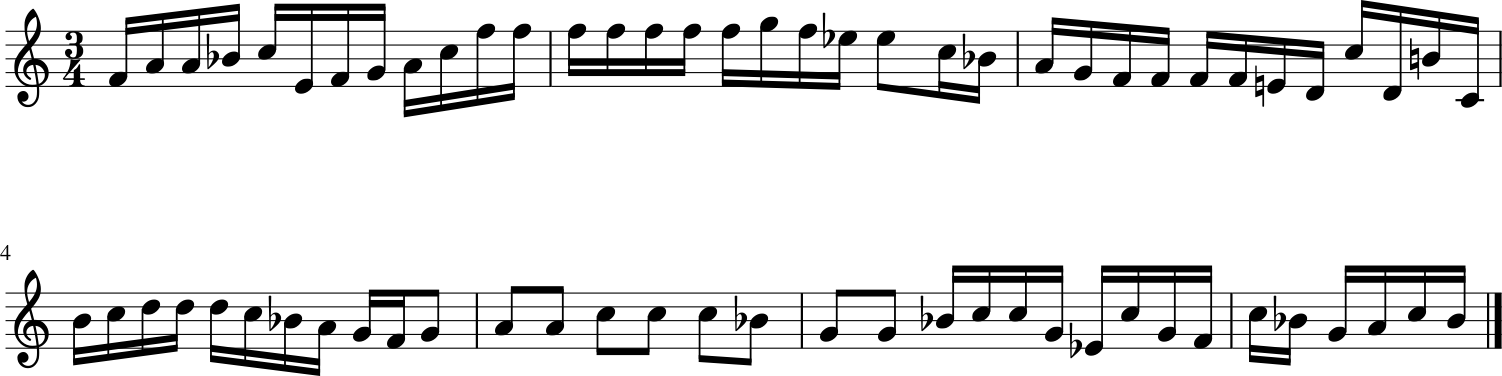

2904/2904 [==============================] - 45s 16ms/step - loss: 2.6847 - note_outputs_loss: 2.0892 - duration_outputs_loss: 0.5955
Epoch 5/50
2902/2904 [============================>.] - ETA: 0s - loss: 2.6649 - note_outputs_loss: 2.0699 - duration_outputs_loss: 0.5949[['START', '3/4TS', 'C5', 'C5', 'C6', 'C6', 'C6', 'C6', 'B5', 'C6', 'F6', 'C6', 'B-5', 'G#5', 'G5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'G5', 'G5', 'A5', 'A5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'F5', 'G5', 'G5', 'E5', 'F5', 'A5', 'F5', 'F5', 'B-4', 'F5', 'E-5', 'F5', 'A5', 'F5', 'E5', 'F5', 'F5', 'E5'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25

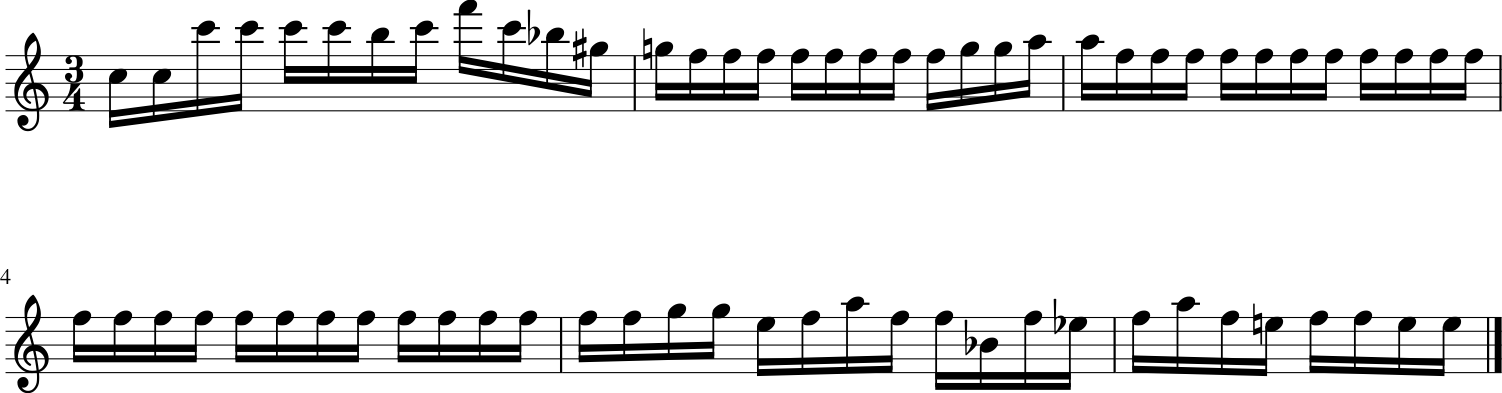

2904/2904 [==============================] - 52s 18ms/step - loss: 2.6646 - note_outputs_loss: 2.0698 - duration_outputs_loss: 0.5949
Epoch 6/50
2903/2904 [============================>.] - ETA: 0s - loss: 2.6503 - note_outputs_loss: 2.0558 - duration_outputs_loss: 0.5945[['START', '2/4TS', 'A5', 'rest', 'G5', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'G5', 'rest', 'G5', 'rest', 'A5', 'G5', 'E5', 'E5', 'E5', 'E5', 'E5', 'rest', 'E5', 'rest', 'E5', 'rest', 'E5', 'rest', 'E5', 'rest', 'F5', 'rest', 'A5', 'rest', 'G5', 'rest', 'A5', 'rest', 'G5', 'rest', 'A5', 'G5', 'F#5', 'G5', 'G5', 'G5', 'G5', 'G4', 'G5', 'rest', 'G5', 'rest', 'A5', 'rest', 'G5', 'rest', 'F#5', 'E5', 'rest', 'G5', 'rest', 'G5', 'rest', 'G5', 'rest', 'G5', 'rest'], ['0.0', '1/12', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.

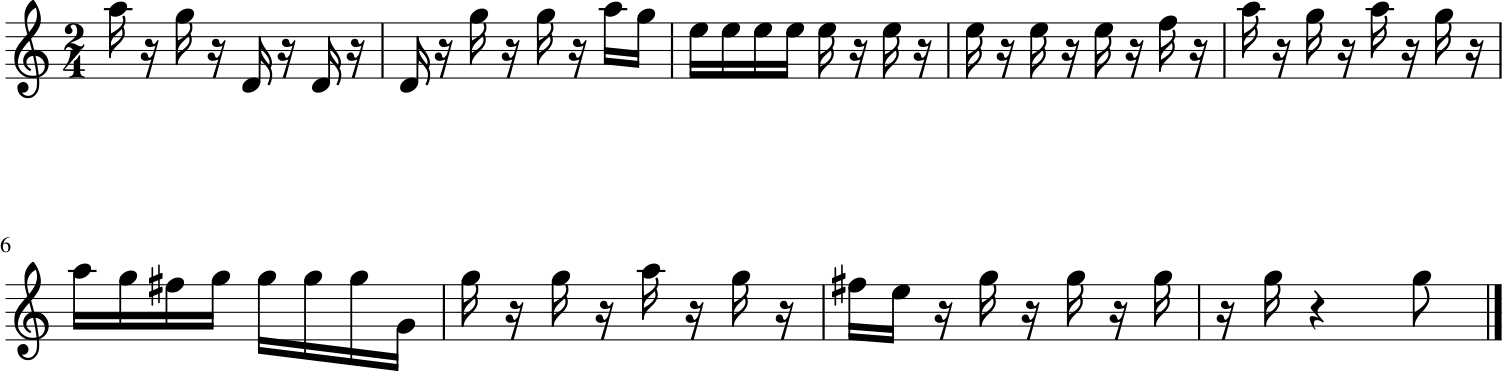

2904/2904 [==============================] - 48s 16ms/step - loss: 2.6504 - note_outputs_loss: 2.0558 - duration_outputs_loss: 0.5946
Epoch 7/50
2903/2904 [============================>.] - ETA: 0s - loss: 2.6379 - note_outputs_loss: 2.0439 - duration_outputs_loss: 0.5940[['START', '6/8TS', 'B5', 'G5', 'C#5', 'C#5', 'D5', 'F#5', 'E5', 'A5', 'E5', 'B5', 'A5', 'G#5', 'A5', 'B5', 'A5', 'G#5', 'F#5', 'E5', 'D5', 'C#5', 'B4', 'A4', 'B4', 'C#5', 'E5', 'C#5', 'A4', 'B4', 'A4', 'A4', 'B4', 'C#5', 'E4', 'E4', 'B4', 'A4', 'E4', 'C#4', 'E4', 'A4', 'A4', 'A4', 'A4', 'A4', 'E4', 'B4', 'E4', 'B4', 'C#5', 'C#5', 'C#5', 'E5', 'D5', 'B4', 'B4', 'C#5', 'E5', 'C#5', 'E4', 'C#5', 'A4', 'F5', 'D5', 'C#5', 'B4', 'A4', 'A4'], ['0.0', '0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0

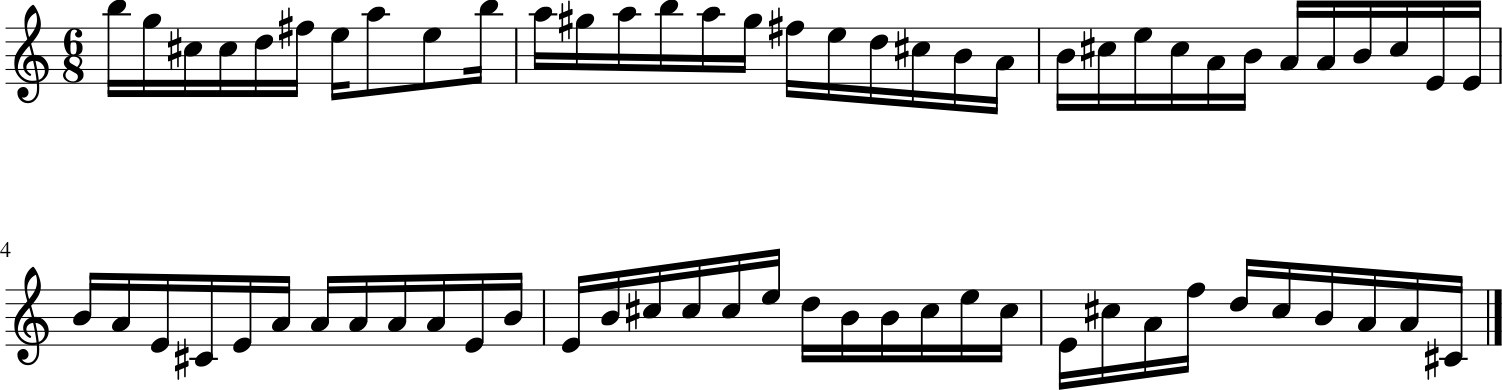

2904/2904 [==============================] - 45s 15ms/step - loss: 2.6381 - note_outputs_loss: 2.0441 - duration_outputs_loss: 0.5941
Epoch 8/50
2904/2904 [==============================] - ETA: 0s - loss: 2.6237 - note_outputs_loss: 2.0310 - duration_outputs_loss: 0.5927[['START', '3/4TS', 'B4', 'B4', 'B4', 'D5', 'C5', 'B4', 'B4', 'C5', 'D5', 'D5', 'C5', 'B4', 'A4', 'G4', 'G4', 'G4', 'A4', 'A4', 'A4', 'G4', 'G4', 'G4', 'G4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'B4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'C5', 'A4', 'A4', 'A4', 'G4', 'F4', 'E4', 'F4', 'E4', 'D4', 'C4', 'C4', 'D4', 'rest', 'D5', 'E4', 'E4', 'E5', 'E5', 'E5', 'F5', 'F4', 'A4', 'C5', 'C4', 'rest', 'A4', 'rest', 'A4', 'A4', 'C5'], ['0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', 

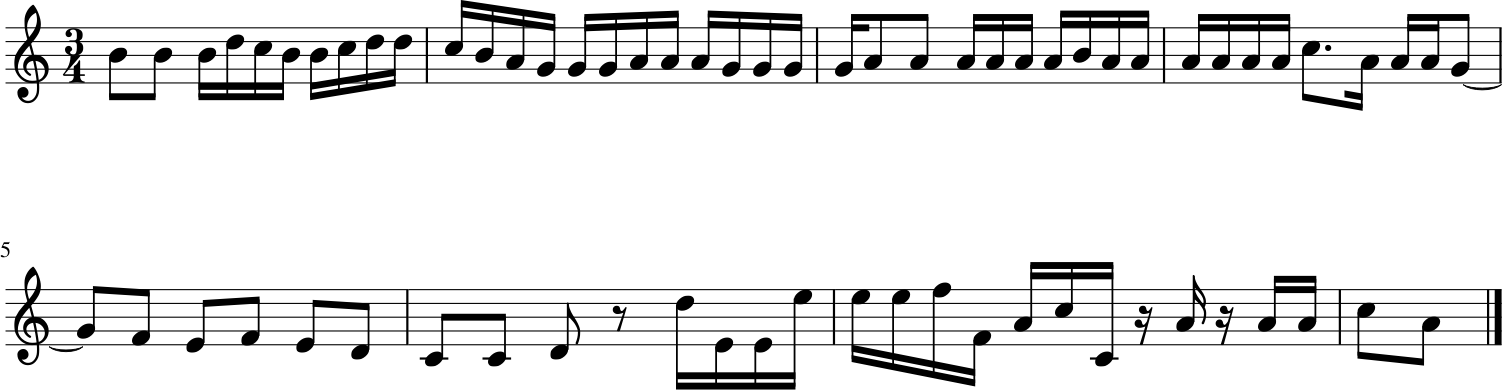

2904/2904 [==============================] - 45s 16ms/step - loss: 2.6237 - note_outputs_loss: 2.0310 - duration_outputs_loss: 0.5927
Epoch 9/50
2900/2904 [============================>.] - ETA: 0s - loss: 2.6117 - note_outputs_loss: 2.0206 - duration_outputs_loss: 0.5912[['START', '3/4TS', '3/4TS', 'F4', 'F4', 'F4', 'E4', 'E4', 'D4', 'C4', 'B-3', 'A3', 'A3', 'G3', 'G3', 'F3', 'E3', 'F3', 'F3', 'E3', 'D3', 'D3', 'D3', 'D3', 'D3', 'C3', 'C3', 'D3', 'C3', 'B-2', 'B-2', 'A2', 'A2', 'C3', 'C3', 'C3', 'F3', 'C3', 'D3', 'C3', 'D3', 'C3', 'C3', 'B-2', 'B-2', 'A2', 'A2', 'A2', 'C3', 'C3', 'C3', 'B-2', 'D3', 'C3', 'B-2', 'B-2', 'B-2', 'D3', 'A2', 'A2', 'A2', 'G2', 'B-2', 'A2', 'B-2', 'A2', 'B-2', 'B-2', 'B-2'], ['0.0', '3.5', '1.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '1/6', '1/12', '1/6', '1/12', '1/6', '1/6', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5',

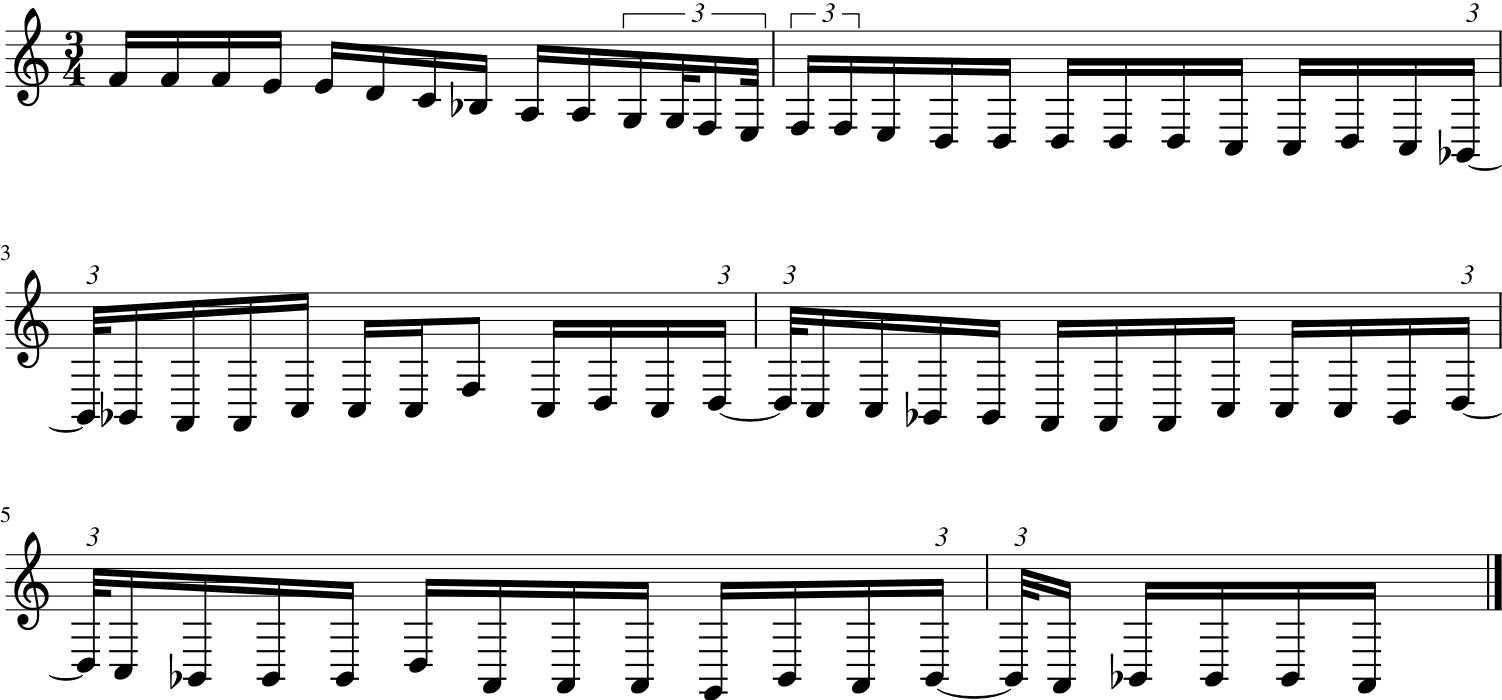

2904/2904 [==============================] - 45s 16ms/step - loss: 2.6119 - note_outputs_loss: 2.0207 - duration_outputs_loss: 0.5912
Epoch 10/50
2902/2904 [============================>.] - ETA: 0s - loss: 2.5996 - note_outputs_loss: 2.0078 - duration_outputs_loss: 0.5918[['START', '2/4TS', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0

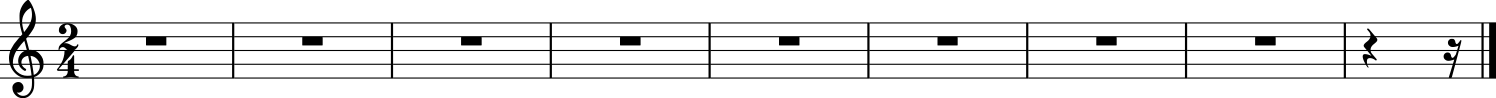

2904/2904 [==============================] - 46s 16ms/step - loss: 2.5999 - note_outputs_loss: 2.0077 - duration_outputs_loss: 0.5922
Epoch 11/50
2903/2904 [============================>.] - ETA: 0s - loss: 2.5894 - note_outputs_loss: 1.9990 - duration_outputs_loss: 0.5904[['START', '3/4TS', 'F6', 'F6', 'F6', 'F6', 'F6', 'F6', 'F6', 'E-6', 'E-6', 'D6', 'D6', 'D6', 'E-6', 'E-6', 'E-6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6', 'E6'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.

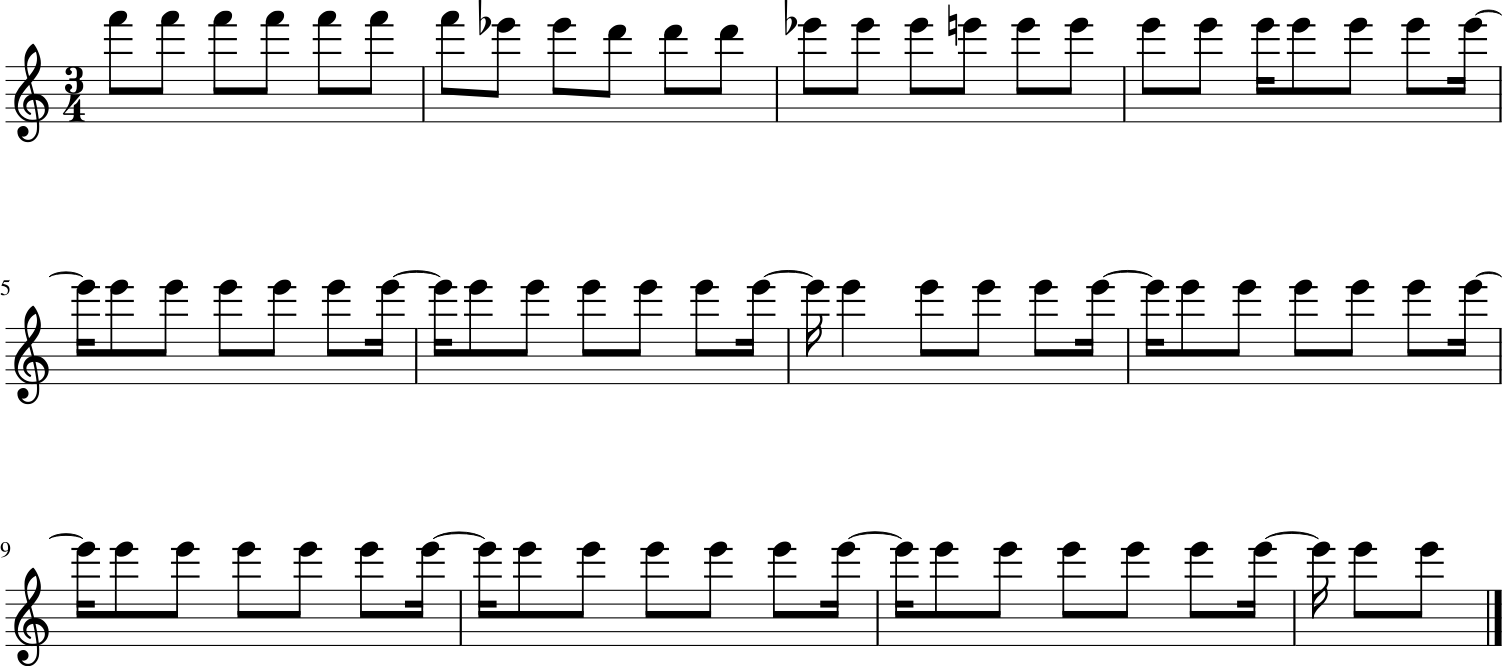

2904/2904 [==============================] - 46s 16ms/step - loss: 2.5897 - note_outputs_loss: 1.9991 - duration_outputs_loss: 0.5906
Epoch 12/50
 949/2904 [========>.....................] - ETA: 24s - loss: 2.6198 - note_outputs_loss: 2.0500 - duration_outputs_loss: 0.5697

KeyboardInterrupt: 

In [125]:
model.fit(
    ds,
    epochs=50,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator,
    ],
)

## Generations

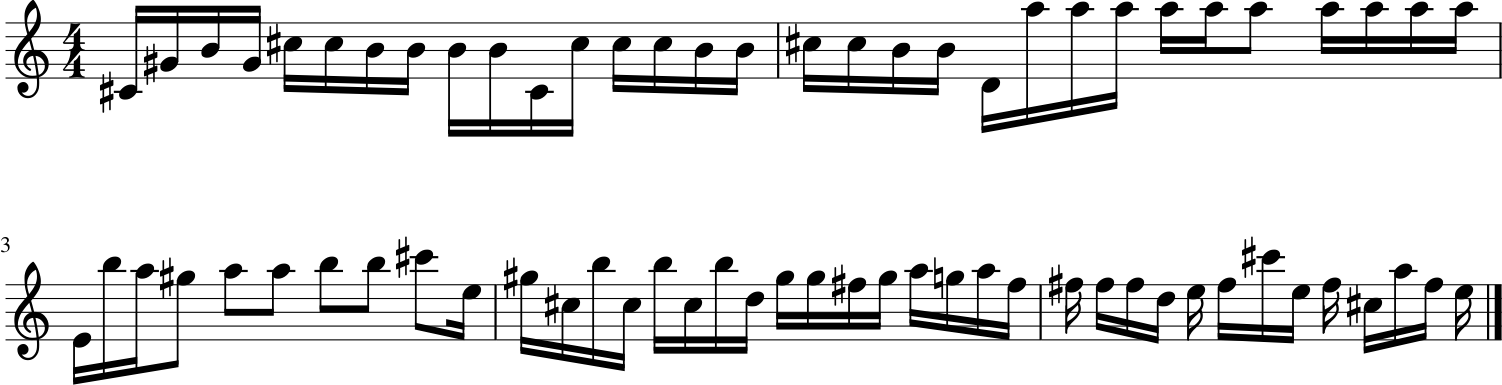

In [126]:
starting_notes = ["C#4", "G#4", "B"]
starting_durations = ["0.5", "0.5", "0.5"]

info = music_generator.generate(
    starting_notes, starting_durations, max_tokens=70, temperature=0.9
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")


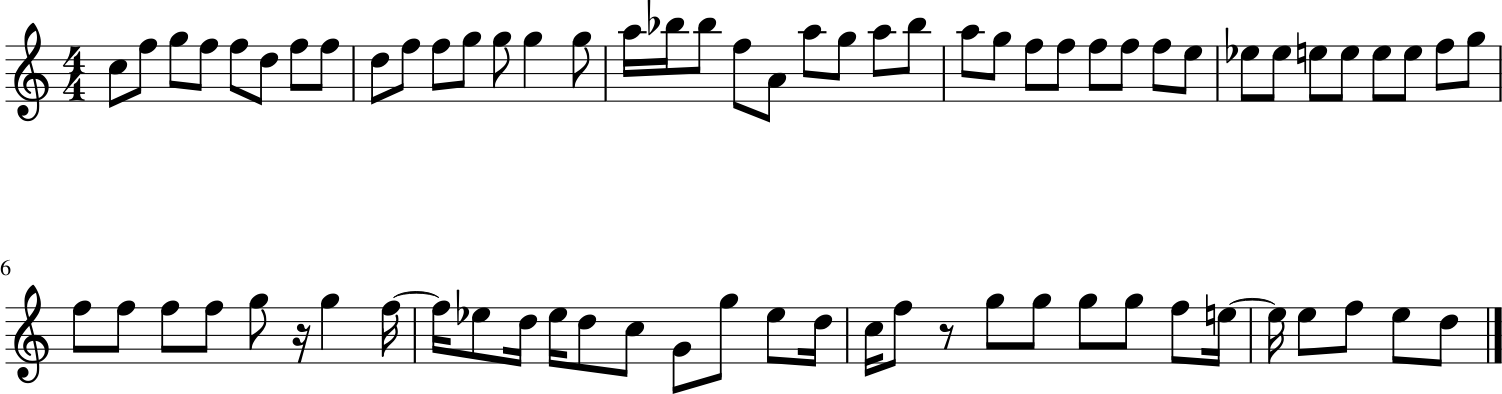

In [127]:
starting_notes = ["C5", "F5", "G5"]
starting_durations = ["0.5", "0.5", "0.5"]

info = music_generator.generate(
    starting_notes, starting_durations, max_tokens=70, temperature=0.9
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

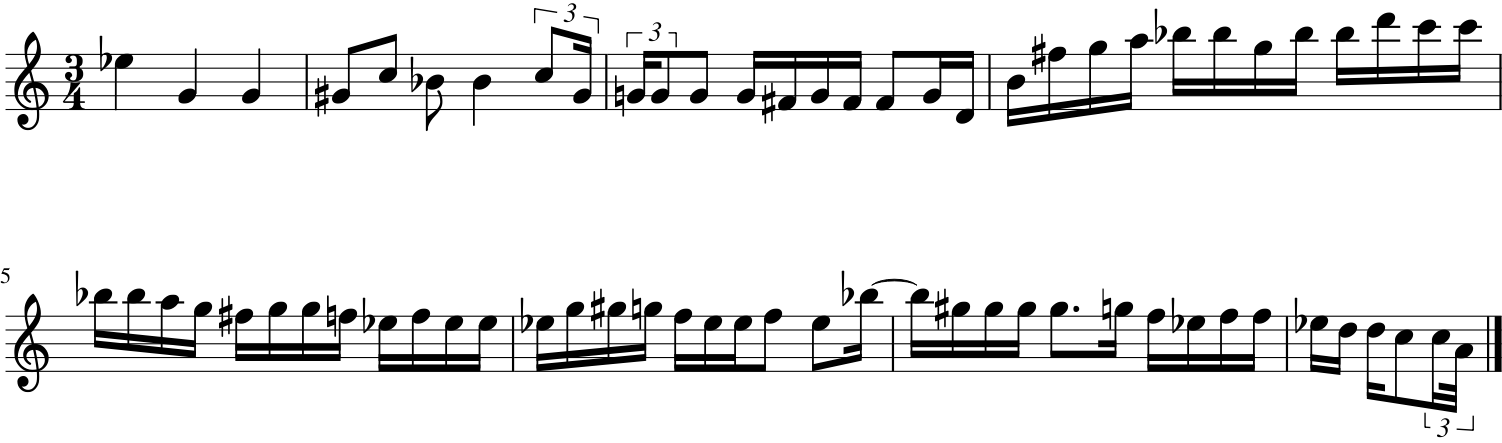

In [128]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=70, temperature=1
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

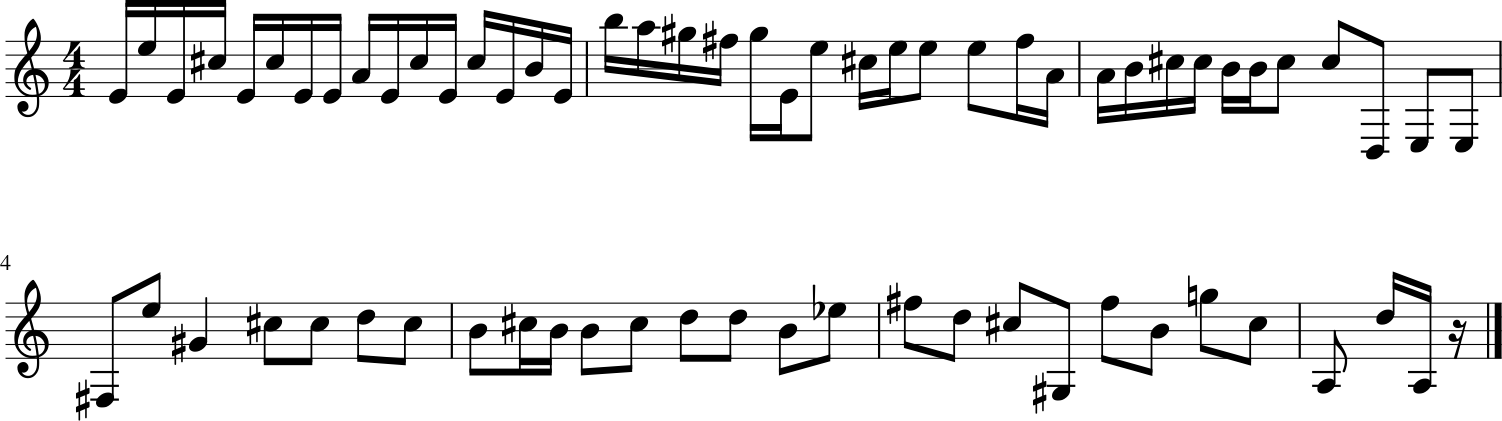

In [129]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=70, temperature=0.9
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

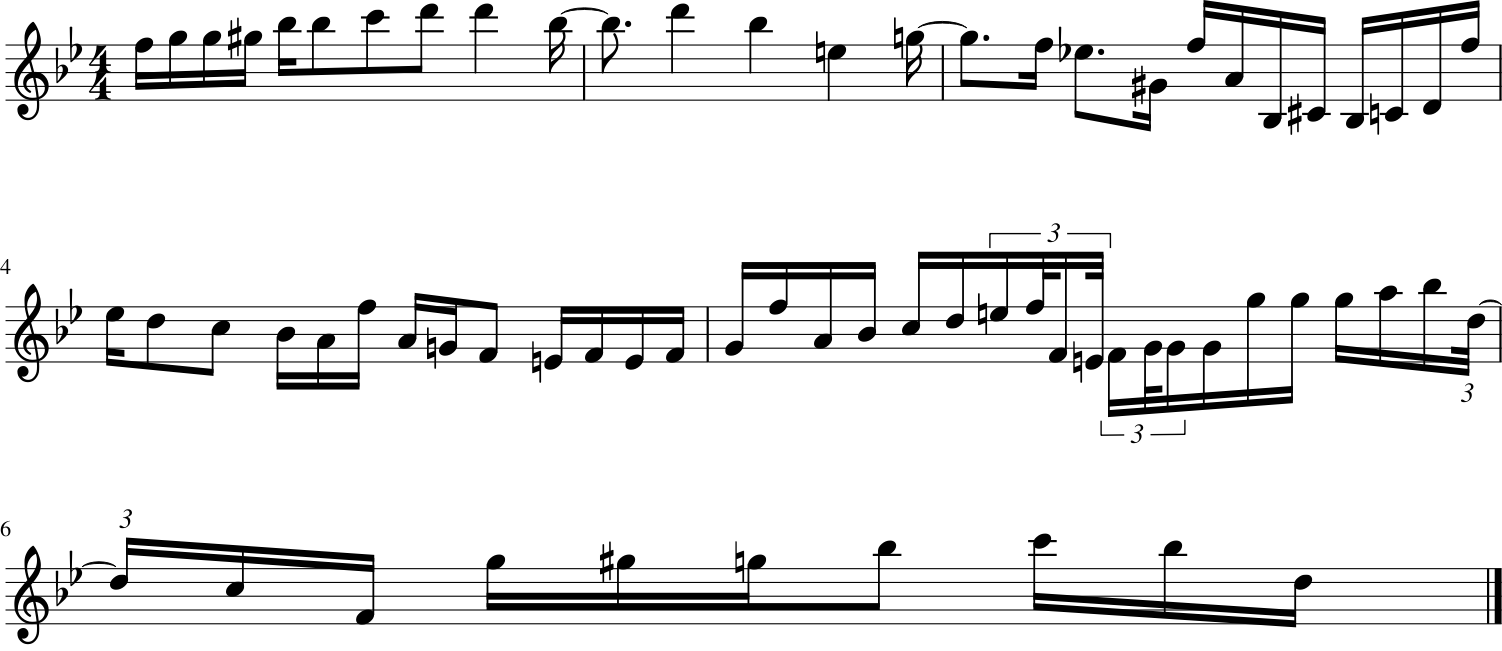

In [134]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=70, temperature=1
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

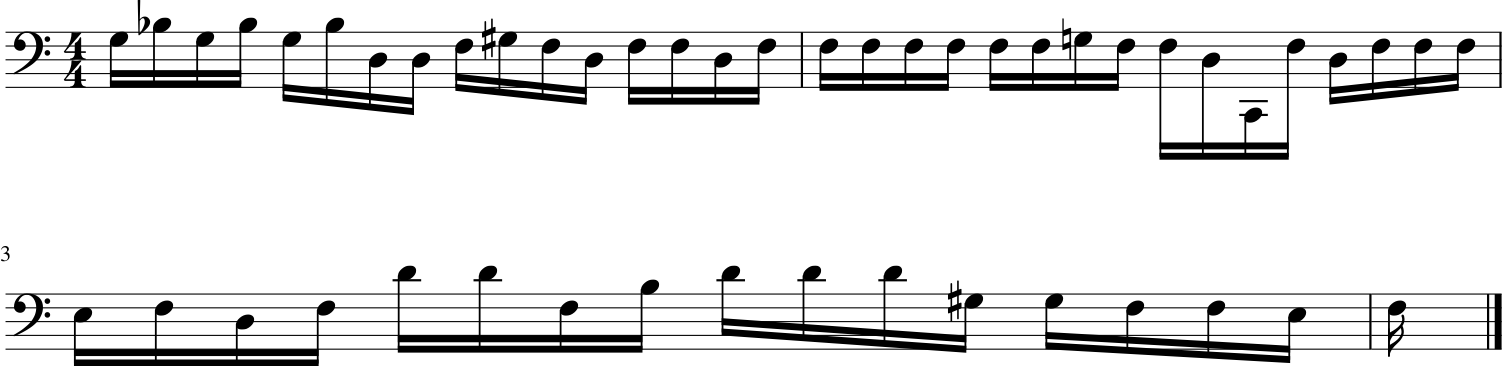

In [67]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

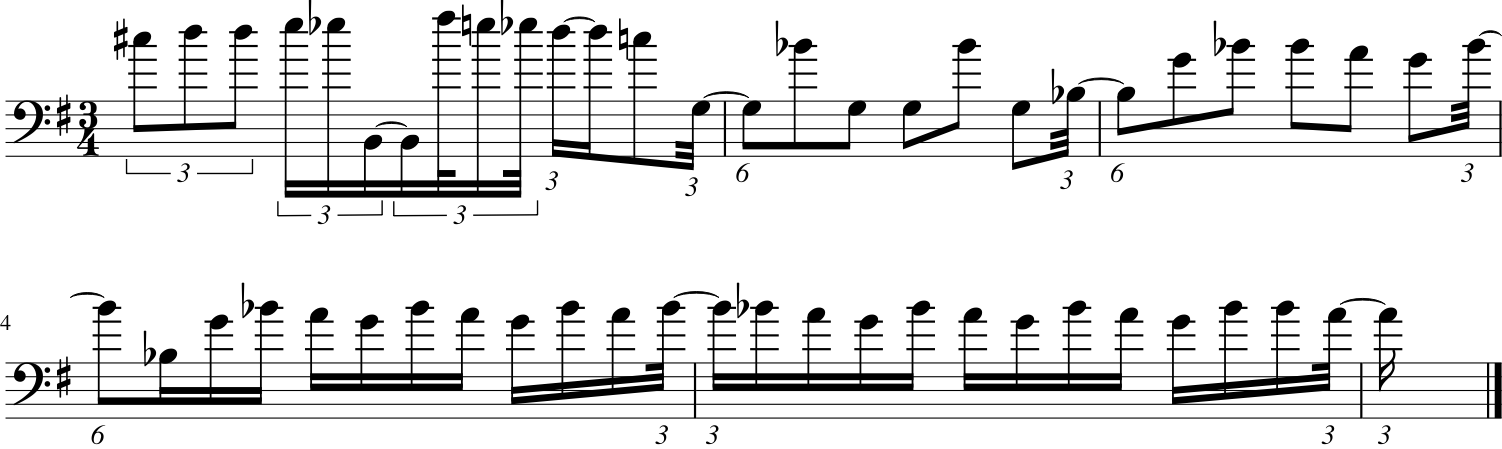

In [41]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.8
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

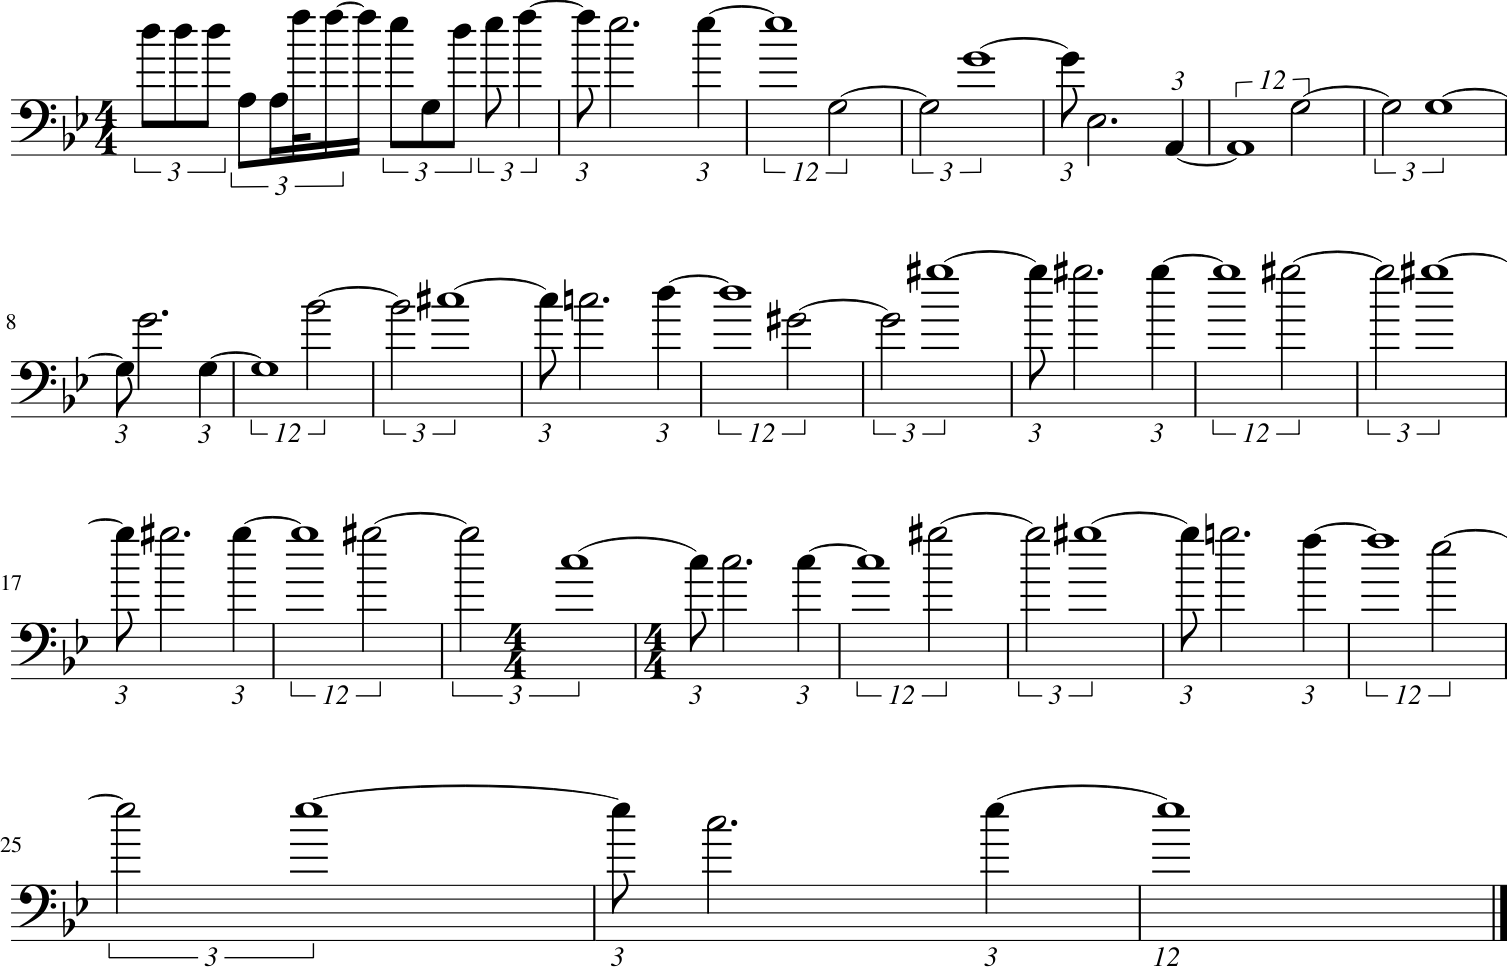

In [46]:
info = music_generator.generate(
    ["START"], ["G:Major"], max_tokens=50, temperature=1
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

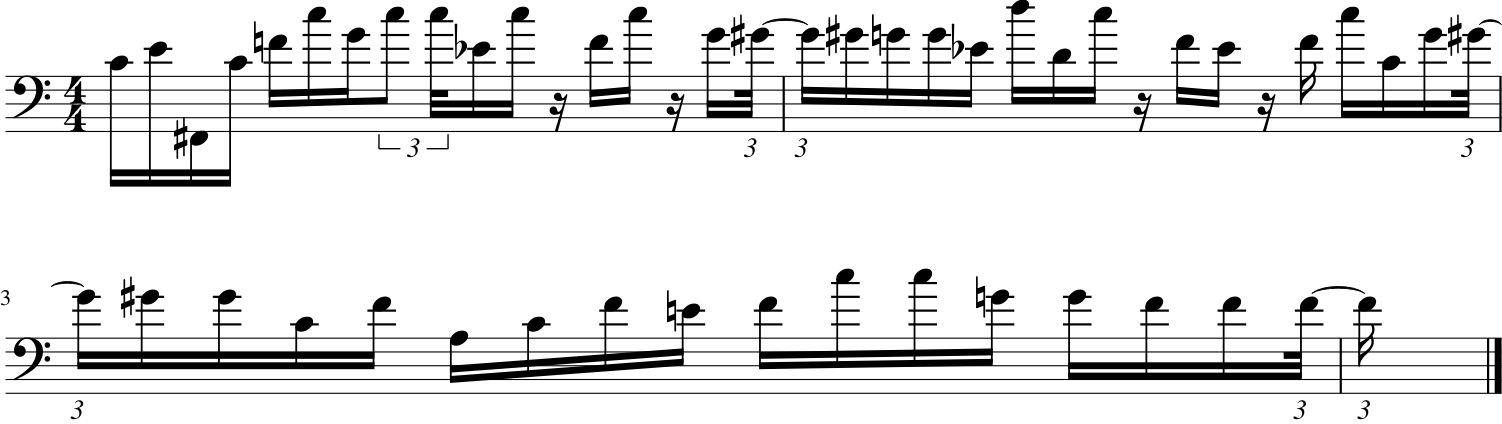

In [82]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.9
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

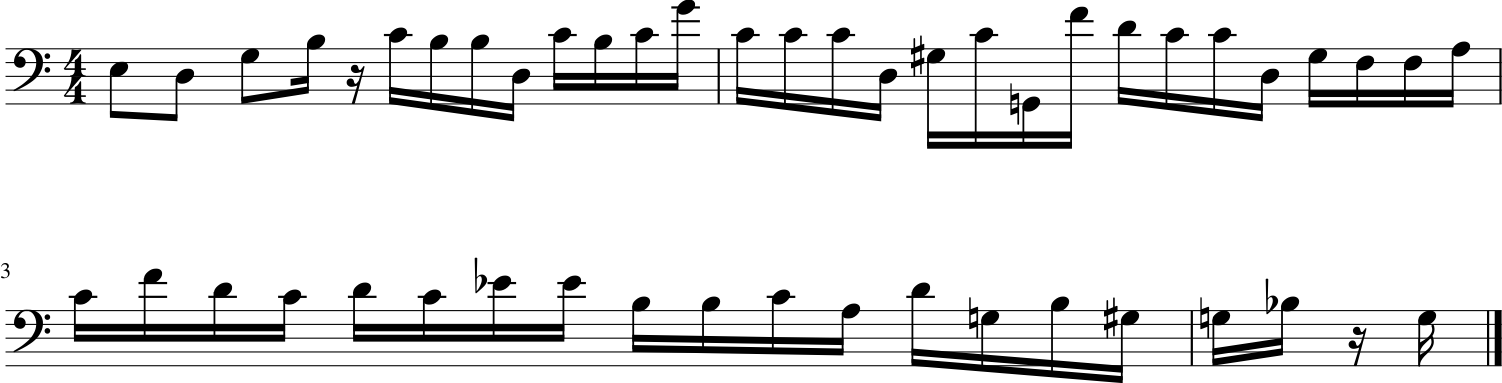

In [77]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=1
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

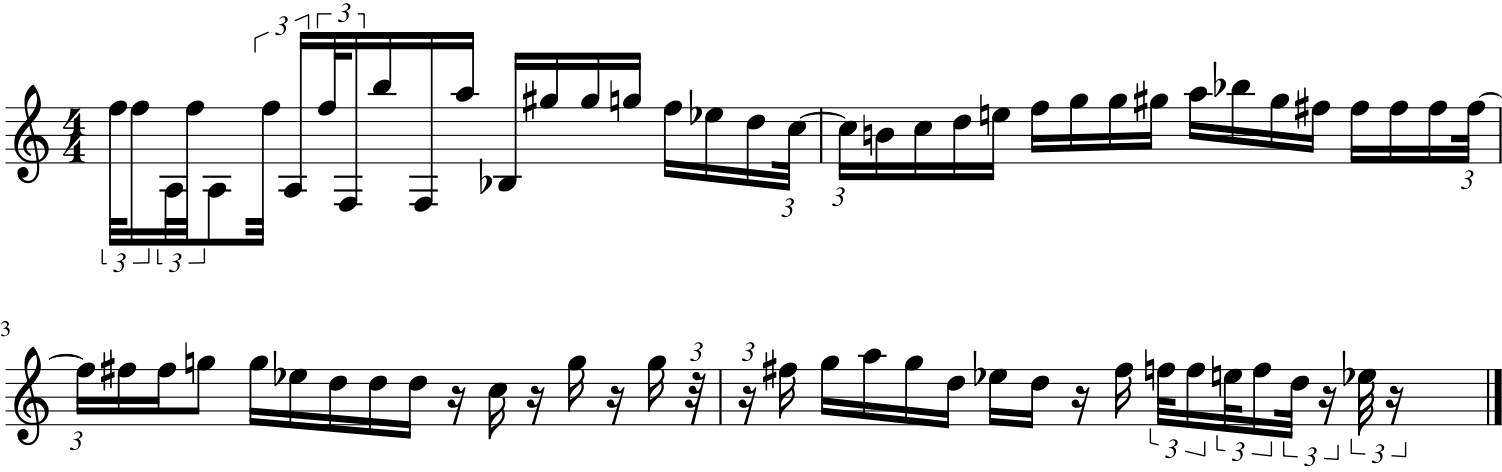

In [135]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=70, temperature=1
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

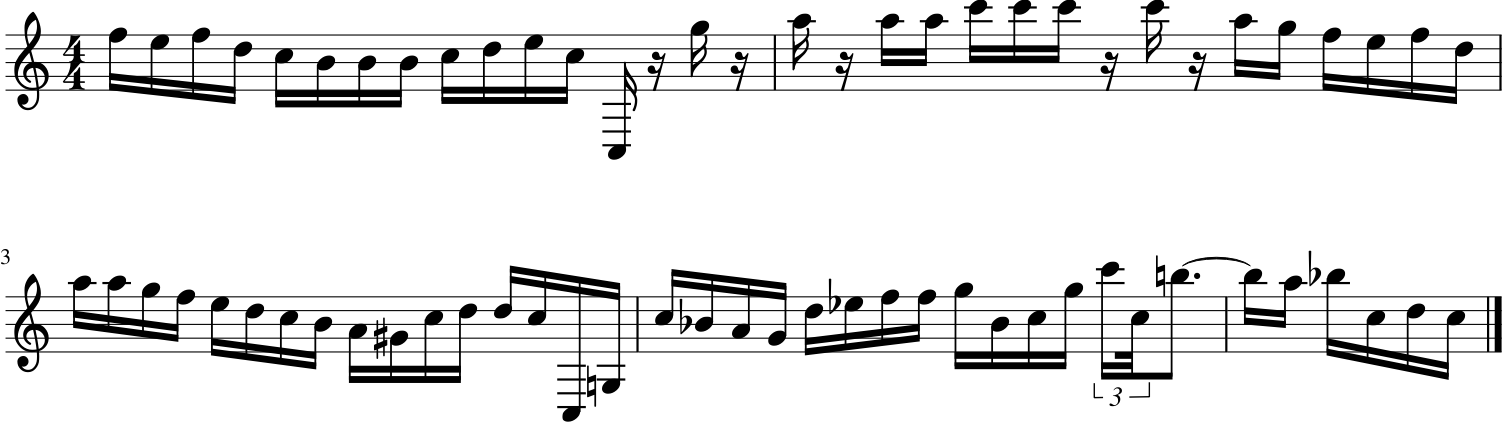

In [136]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=70, temperature=0.85
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

In [137]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/output",
        "output-" + timestr + ".mid",
    ),
)

'/content/output/output-20240229-142156.mid'

In [138]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

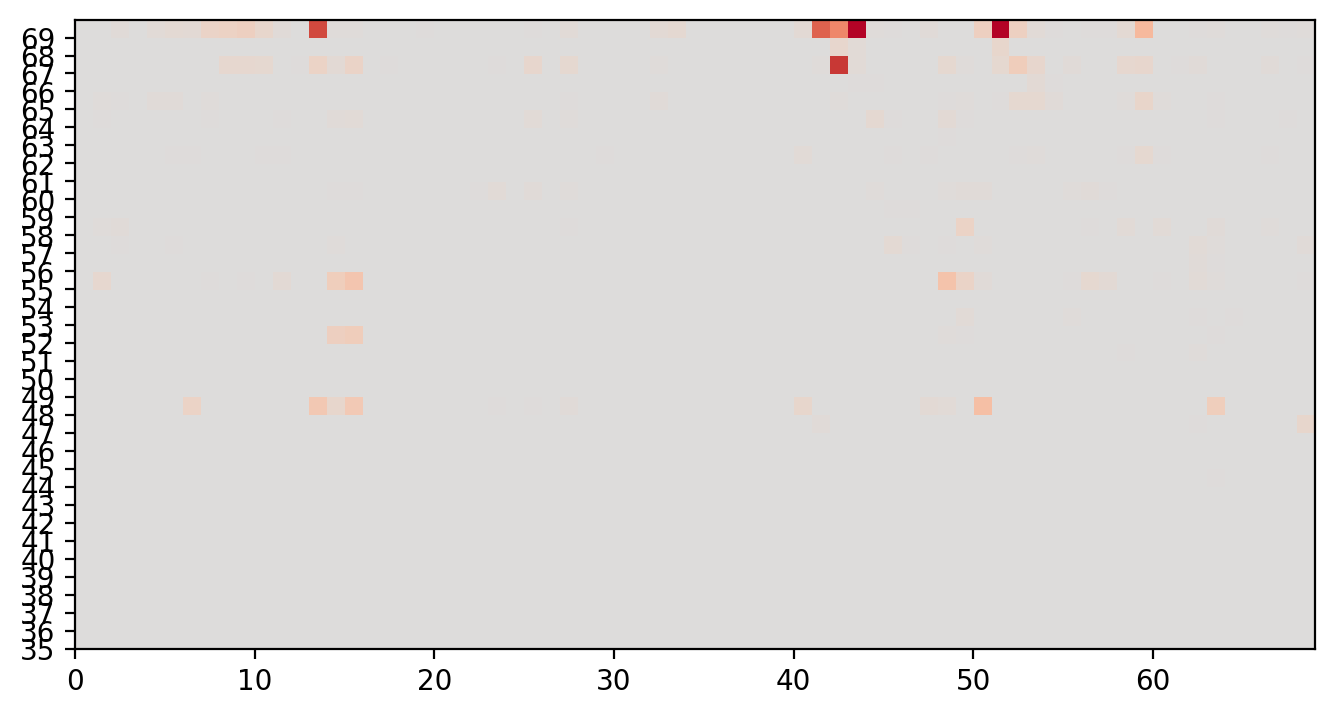

In [139]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

In [140]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [141]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

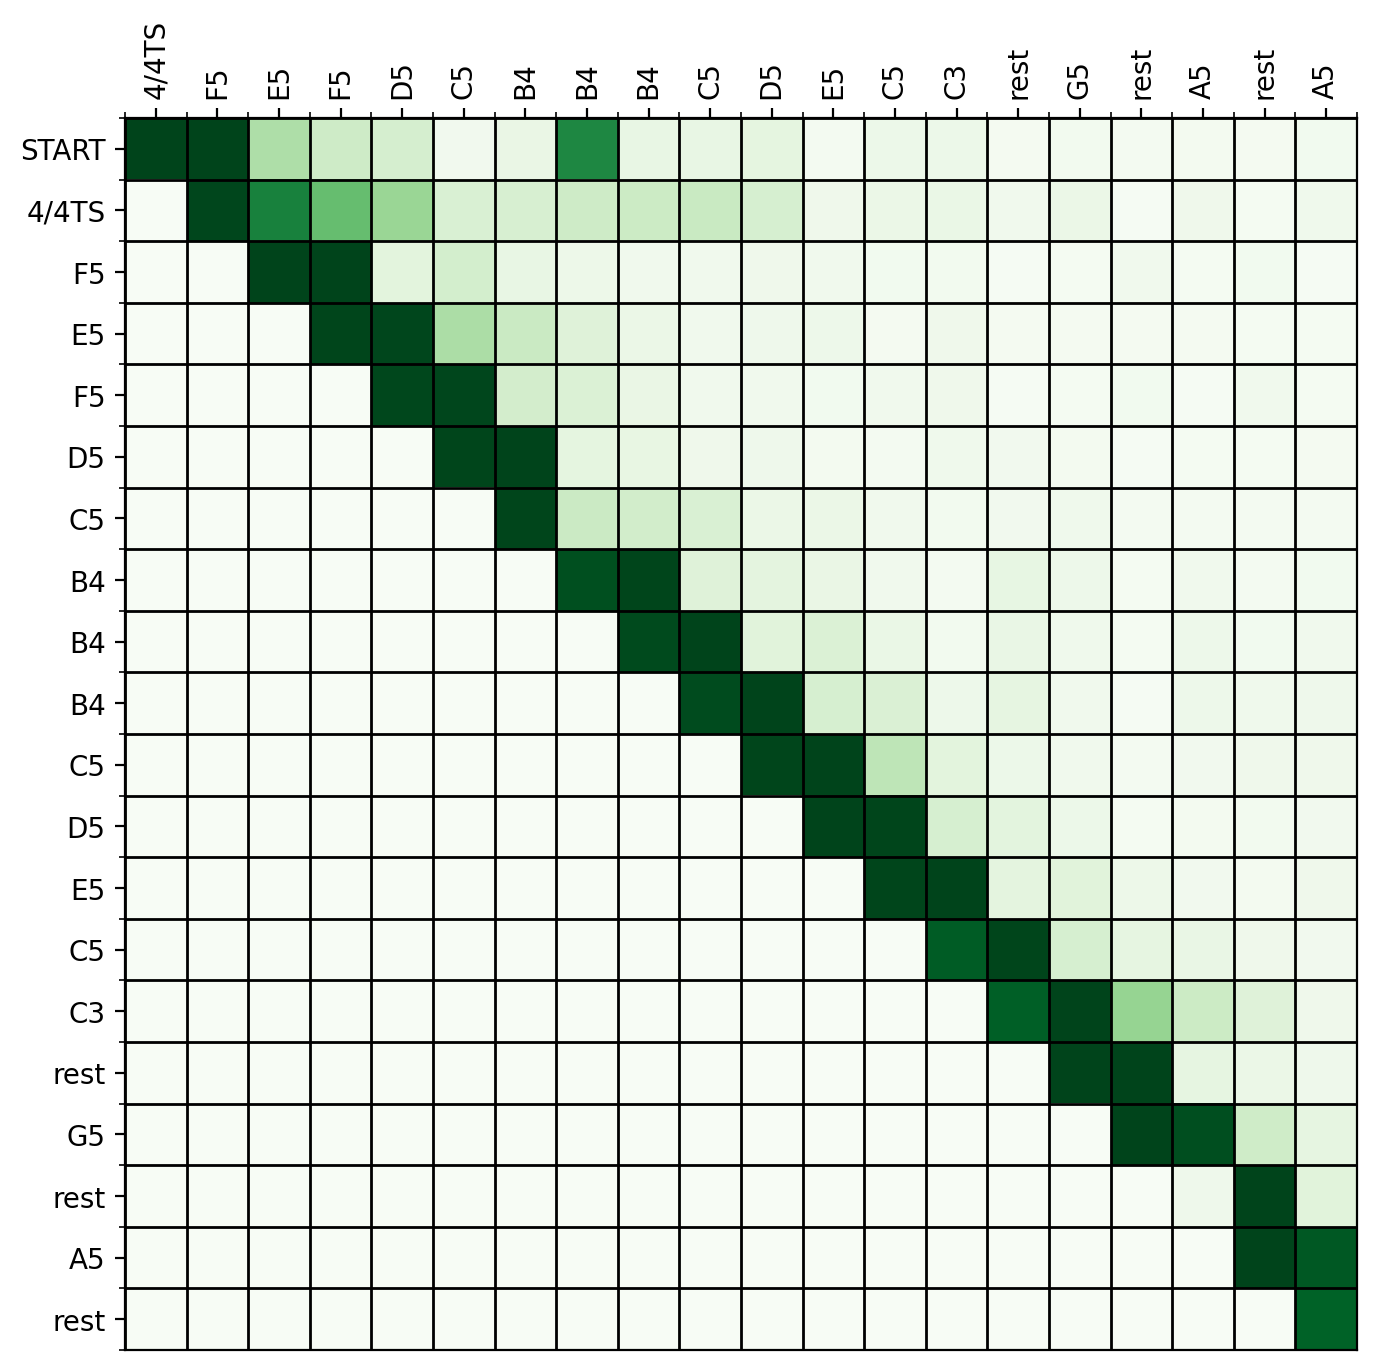

In [142]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()

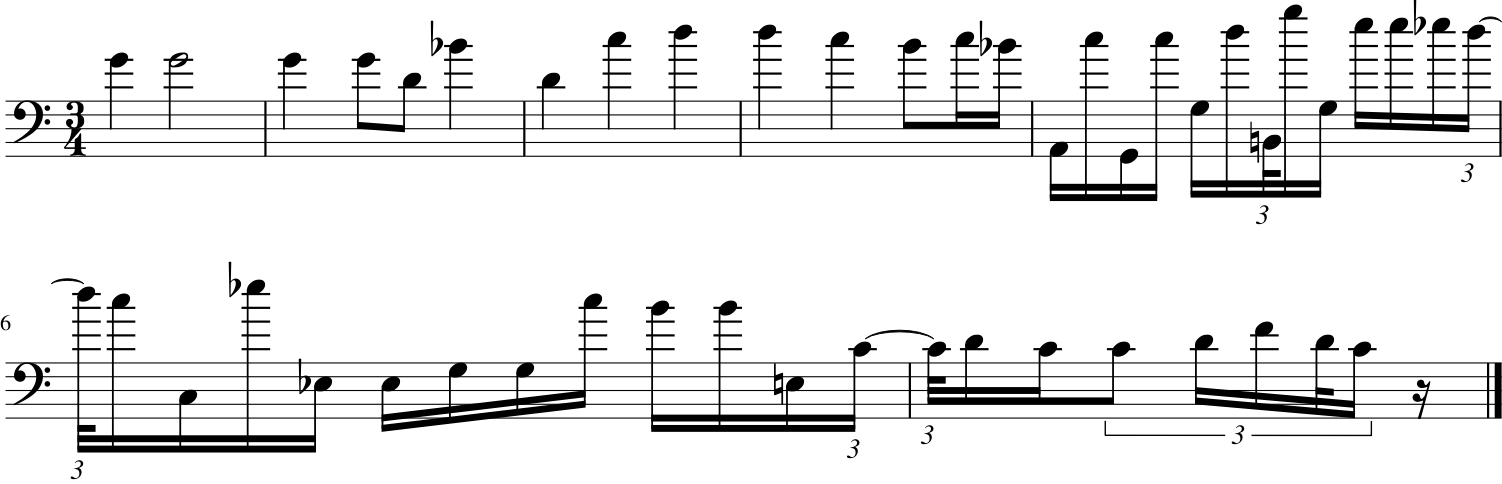

In [60]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=1
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

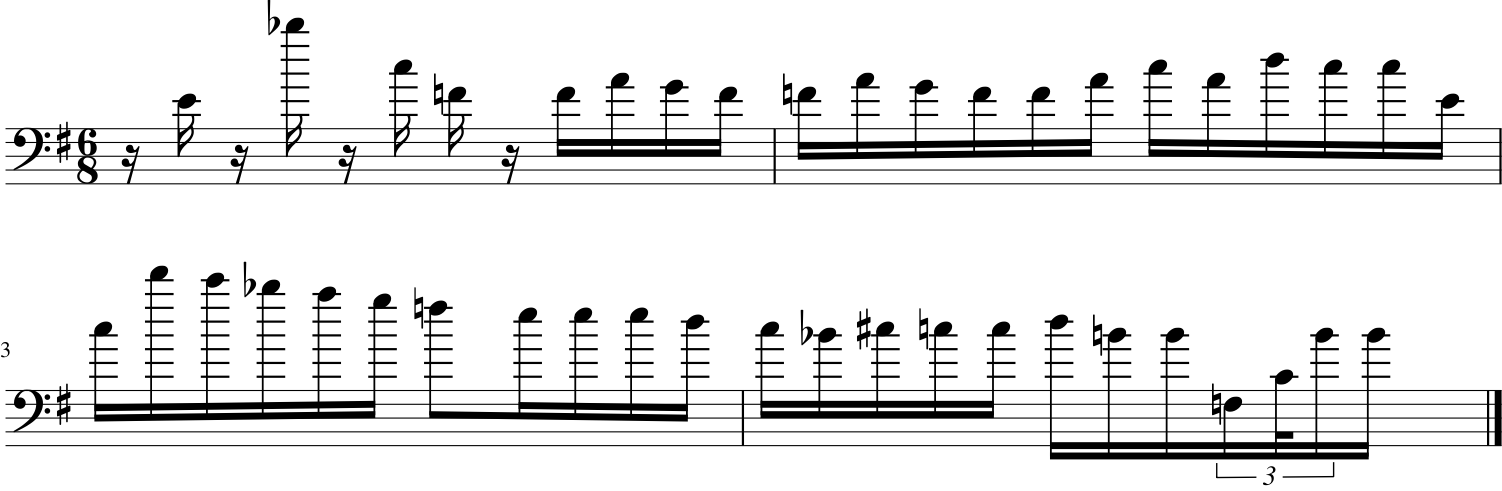

In [63]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=1
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

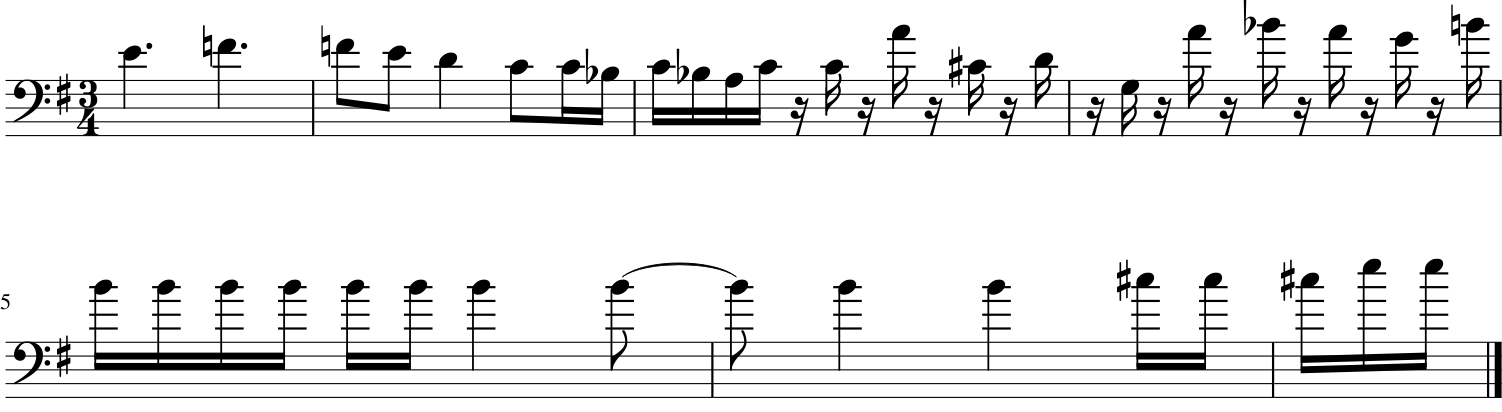

In [64]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=1
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

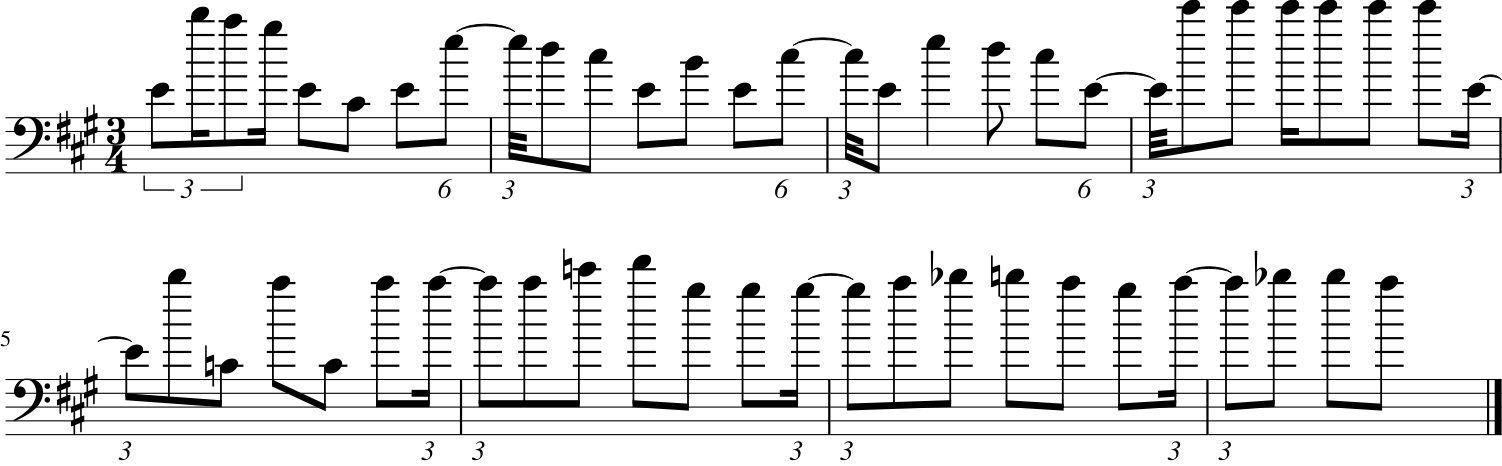

In [68]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.9
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

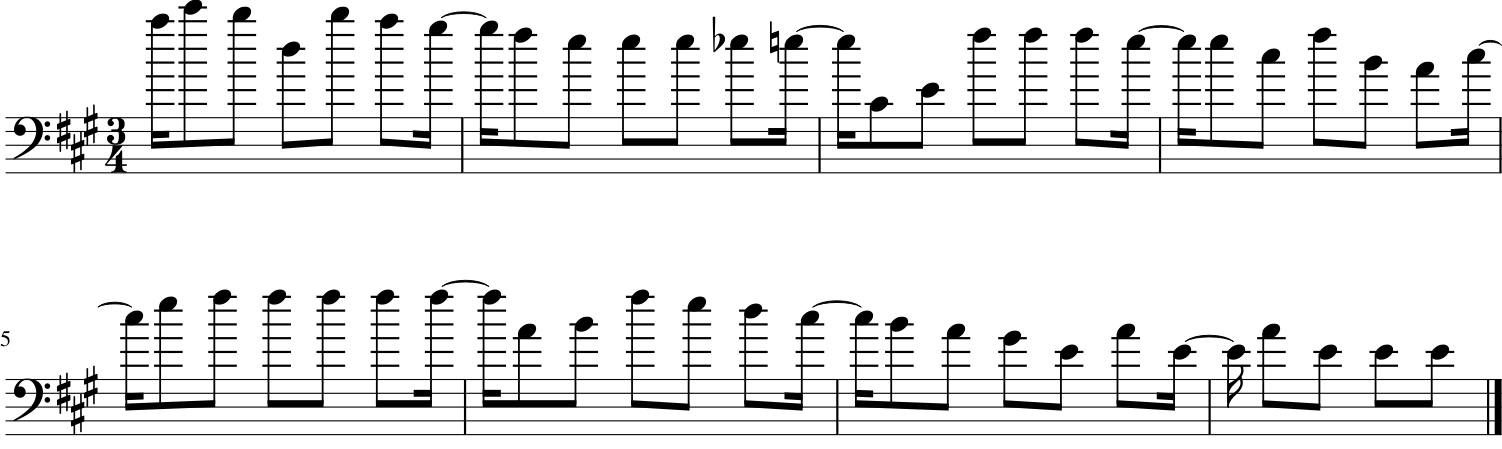

In [71]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.6
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

In [87]:
nx = notes[1000].chordify()
nx.show()

nx.show("midi")

AttributeError: 'str' object has no attribute 'chordify'

In [88]:
notes[1000]

'D5 F#4 G4 F5 F5 F5 F5 G5 F5 A5 G5 F5 E5 D5 C5 B4 C5 D5 E5 F5 G5 A5 B5 C6 D6 E6 F6 E-6 E-6 E-6 E-6 E6 E6 E4 E4 G4 E5 E5 E5 E5 C6 E6 C6 A5 D5 D5 D5 D5 B5 D6 B5'

In [91]:
durations[1000]

'0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 1/6 1/12 0.25 1/3 1/6 1/12 1/12 1/3 1/3 1/3 1/3 1/3 1/6 1/12 1/12 1/3 1/3 1/3'

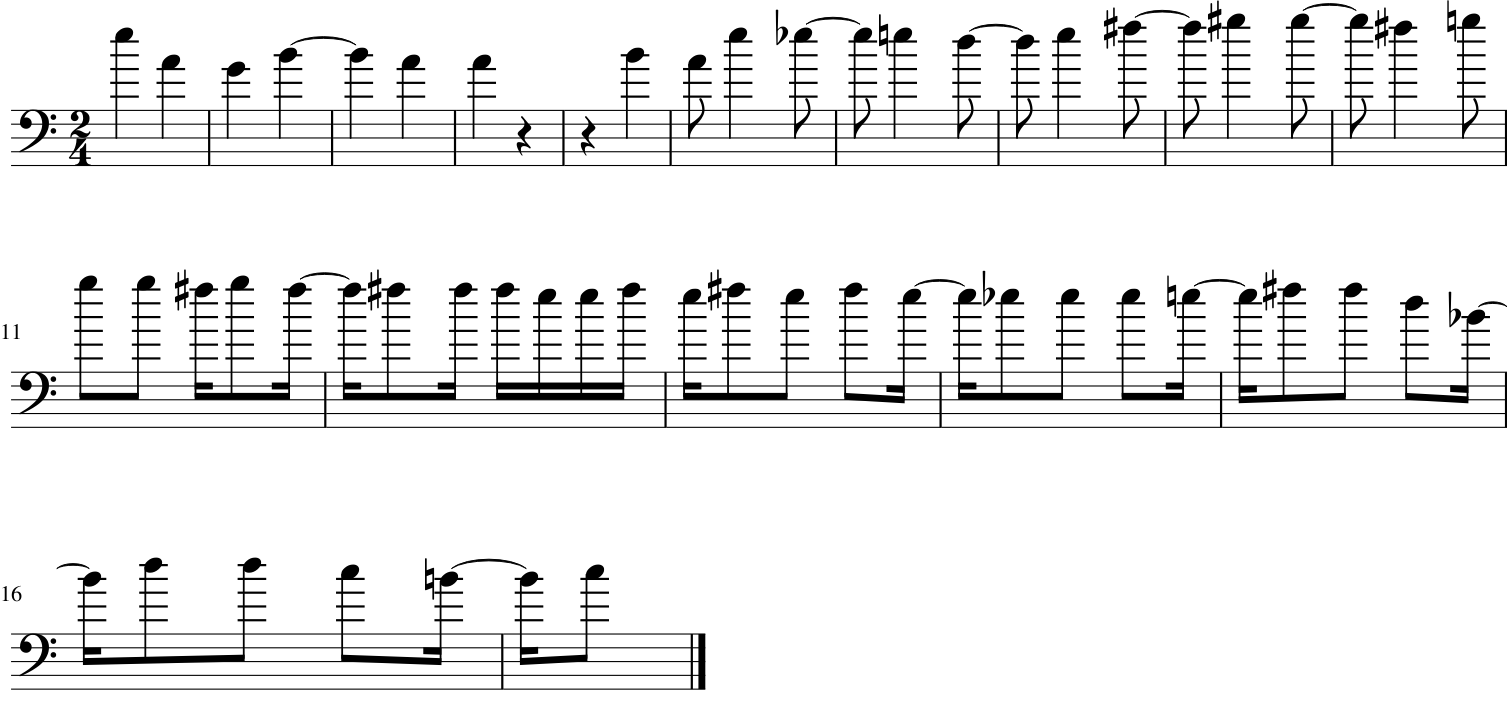

In [89]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=1
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

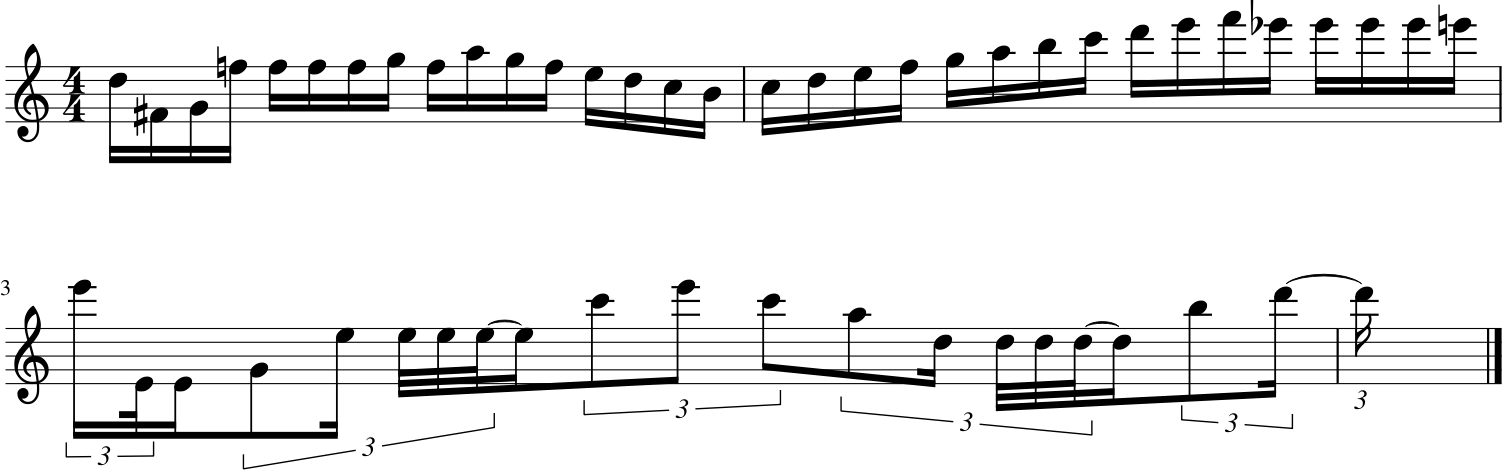

In [94]:
import music21
from fractions import Fraction

notesx = ["D5", "F#4", "G4", "F5", "F5", "F5", "F5", "G5", "F5", "A5", "G5", "F5", "E5", "D5", "C5", "B4", "C5", "D5", "E5", "F5", "G5", "A5", "B5", "C6", "D6", "E6", "F6", "E-6", "E-6", "E-6", "E-6", "E6", "E6", "E4", "E4", "G4", "E5", "E5", "E5", "E5", "C6", "E6", "C6", "A5", "D5", "D5", "D5", "D5", "B5", "D6", "B5"]
durationsx = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, float(Fraction(1, 6)), float(Fraction(1, 12)), 0.25, float(Fraction(1, 3)), float(Fraction(1, 6)), float(Fraction(1, 12)), float(Fraction(1, 12)), float(Fraction(1, 3)), float(Fraction(1, 3)), float(Fraction(1, 3)), float(Fraction(1, 3)), float(Fraction(1, 3)), float(Fraction(1, 6)), float(Fraction(1, 12)), float(Fraction(1, 12)), float(Fraction(1, 3)), float(Fraction(1, 3)), float(Fraction(1, 3))]

midi_stream = music21.stream.Stream()

for note, duration in zip(notesx, durationsx):
    if note == "REST":
        new_note = music21.note.Rest(quarterLength=float(duration))
    else:
        new_note = music21.note.Note(note, quarterLength=float(duration))
    midi_stream.append(new_note)

midi_stream.show()
midi_stream.show("midi")


In [95]:
notesx

['D5',
 'F#4',
 'G4',
 'F5',
 'F5',
 'F5',
 'F5',
 'G5',
 'F5',
 'A5',
 'G5',
 'F5',
 'E5',
 'D5',
 'C5',
 'B4',
 'C5',
 'D5',
 'E5',
 'F5',
 'G5',
 'A5',
 'B5',
 'C6',
 'D6',
 'E6',
 'F6',
 'E-6',
 'E-6',
 'E-6',
 'E-6',
 'E6',
 'E6',
 'E4',
 'E4',
 'G4',
 'E5',
 'E5',
 'E5',
 'E5',
 'C6',
 'E6',
 'C6',
 'A5',
 'D5',
 'D5',
 'D5',
 'D5',
 'B5',
 'D6',
 'B5']

In [97]:
durationsx

[0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.16666666666666666,
 0.08333333333333333,
 0.25,
 0.3333333333333333,
 0.16666666666666666,
 0.08333333333333333,
 0.08333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.16666666666666666,
 0.08333333333333333,
 0.08333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333]

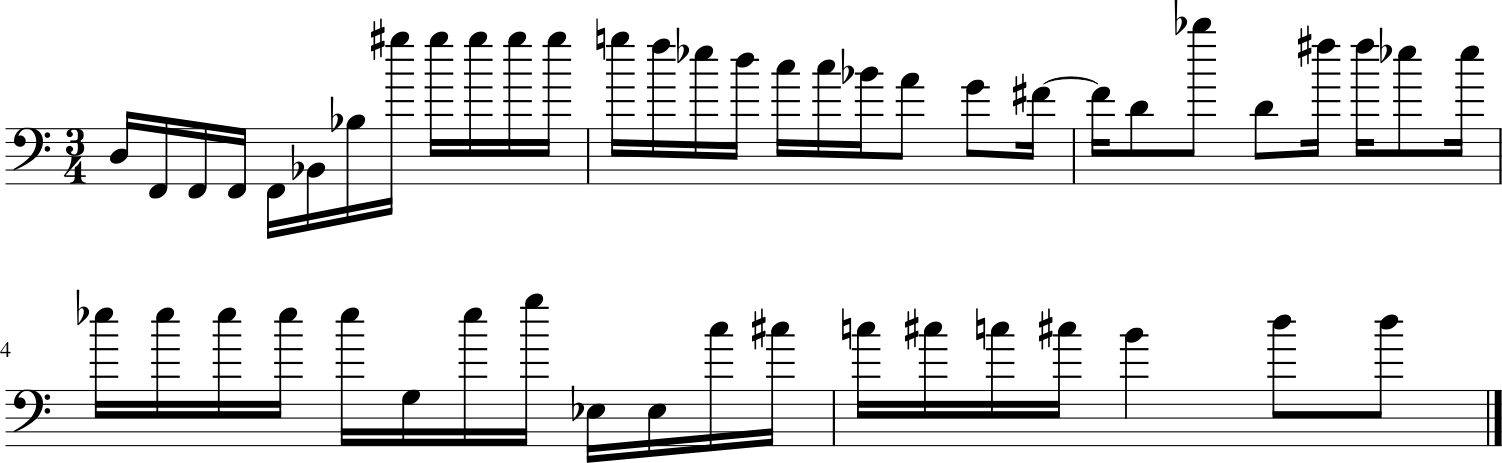

In [98]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=1
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")

In [119]:
info = music_generator.generate(
    ["START"], ["C#5"], max_tokens=50, temperature=1
)
midi_stream = info[-1]["midi"].chordify()



midi_stream.show()
midi_stream.show("midi")

KeyboardInterrupt: 

In [118]:
info

[{'prompt': [['START'], ['0.0']],
  'midi': <music21.stream.Stream 0x793884e8cbe0>,
  'chosen_note': ('3/4TS', '0.5'),
  'note_probs': array([1.84898527e-05, 2.55328378e-05, 6.11955358e-04, 1.04428027e-05,
         1.43715195e-04, 3.12996650e-04, 3.79461271e-05, 1.09646215e-04,
         3.75717391e-05, 2.34785675e-05, 1.19400240e-04, 1.00724993e-03,
         3.79263402e-05, 3.40542931e-04, 1.47197896e-03, 3.72306095e-05,
         3.40457191e-04, 3.11565935e-04, 2.96136976e-04, 3.69878864e-04,
         7.96618260e-05, 1.67954000e-04, 1.96430974e-05, 4.86041499e-05,
         4.95881022e-06, 1.20031022e-04, 6.39211969e-04, 8.65724287e-05,
         9.67814558e-05, 1.76266331e-04, 1.09503788e-04, 2.69163575e-04,
         1.63106938e-06, 2.37591084e-04, 2.24352825e-05, 8.94224577e-05,
         7.07015643e-05, 7.68473721e-04, 7.42519915e-04, 7.34406349e-04,
         1.34972535e-04, 3.40778322e-04, 2.12527672e-03, 2.03959426e-04,
         8.78476494e-05, 5.52582031e-04, 7.27474282e-04, 1.80513

In [112]:
notes_list = []
durations_list = []

for step_info in info:
    # Extract notes and durations from the generated information
    notes = step_info["prompt"][0][1:]  # Exclude the initial "START"
    durations = step_info["prompt"][1][1:]  # Exclude the initial "0.0"

    # Append to the overall lists
    notes_list.extend(notes)
    durations_list.extend(durations)


In [105]:
midi_stream = music21.stream.Stream()
midi_stream.append(music21.clef.TrebleClef())

# Iterate through the notes and durations and add them to the stream
for note, duration in zip(notes_list, durations_list):
    if '/' in note:  # If it's a custom representation like '3/4TS'
        pitch, _ = note.split('/')
        new_note = music21.note.Note(pitch, quarterLength=duration)
    else:
        new_note = music21.note.Note(note, quarterLength=duration)

    midi_stream.append(new_note)

# Show or play the generated music
midi_stream.show()
midi_stream.show("midi")

TypeError: Cannot convert num: 0.5

In [103]:
notes_list[0]

'3/4TS'

In [115]:
import music21

# # Assuming notes_list and durations_list are your generated lists
# notes_list = ['3/4TS', 'D3', 'F2', 'G#5', ...]
# durations_list = [0.25, 0.25, 0.5, 0.25, ...]

# Create a stream with a treble clef
midi_stream = music21.stream.Stream()
midi_stream.append(music21.clef.TrebleClef())

# Iterate through the notes and durations and add them to the stream
for note, duration in zip(notes_list, durations_list):
    if '/' in note:  # If it's a custom representation like '3/4TS'
        pitch, _ = note.split('/')
        if pitch:  # Check if pitch is not empty
            new_note = music21.note.Note(pitch, quarterLength=duration)
            midi_stream.append(new_note)
    else:
        if note:  # Check if note is not empty
            new_note = music21.note.Note(note, quarterLength=duration)
            midi_stream.append(new_note)

# Show or play the generated music
midi_stream.show()
midi_stream.show("midi")

TypeError: Cannot convert num: 0.5

In [116]:
unique_notes= set(notes_list)

list(unique_notes)

['G3',
 'D4',
 'D3',
 'D5',
 '3/4TS',
 'E-3',
 'C#5',
 'F5',
 'G#5',
 'C5',
 'F#5',
 'B4',
 'G4',
 'A4',
 'B-2',
 'E-5',
 'F2',
 'B-4',
 'F#4',
 'B-3',
 'G5',
 'B-5']

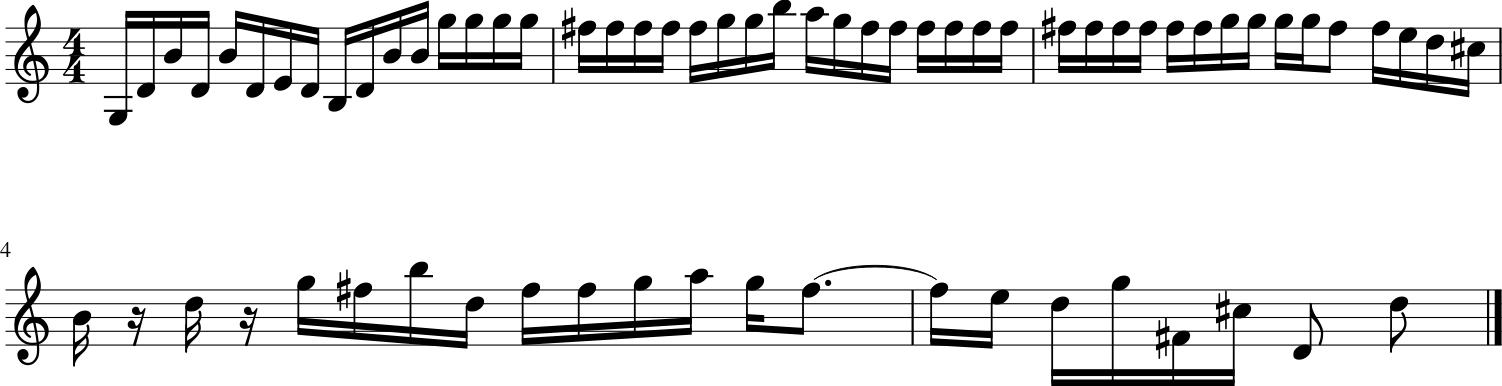

In [144]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=70, temperature=0.85
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()
midi_stream.show("midi")